# Predicting Diabetes - Classifcation Task
Macro F1 score is the evaluation metric

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv("diabetes_train.csv")

## Get to know the data

In [3]:
df_train.head(5)

,Id,num_times_pregnant,plasma_glucose,DBP,triceps_skin,serum_insulin,BMI,pedigree,age,diabetes
0,358,13,129,0,30,0,39.9,0.569,44,1
1,74,4,129,86,20,270,35.1,0.231,23,0
2,353,3,61,82,28,0,34.4,0.243,46,0
3,498,2,81,72,15,76,30.1,0.547,25,0
4,146,0,102,75,23,0,0.0,0.572,21,0


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  576 non-null    int64  
 1   num_times_pregnant  576 non-null    int64  
 2   plasma_glucose      576 non-null    int64  
 3   DBP                 576 non-null    int64  
 4   triceps_skin        576 non-null    int64  
 5   serum_insulin       576 non-null    int64  
 6   BMI                 576 non-null    float64
 7   pedigree            576 non-null    float64
 8   age                 576 non-null    int64  
 9   diabetes            576 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 45.1 KB


## Split Data

In [4]:
from sklearn.model_selection import train_test_split

Id_col = 'Id'
target_col = 'diabetes'

X = df_train.drop([Id_col, target_col], axis=1)
y = df_train[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

array([[<AxesSubplot:title={'center':'num_times_pregnant'}>,
        <AxesSubplot:title={'center':'plasma_glucose'}>,
        <AxesSubplot:title={'center':'DBP'}>],
       [<AxesSubplot:title={'center':'triceps_skin'}>,
        <AxesSubplot:title={'center':'serum_insulin'}>,
        <AxesSubplot:title={'center':'BMI'}>],
       [<AxesSubplot:title={'center':'pedigree'}>,
        <AxesSubplot:title={'center':'age'}>, <AxesSubplot:>]],
      dtype=object)

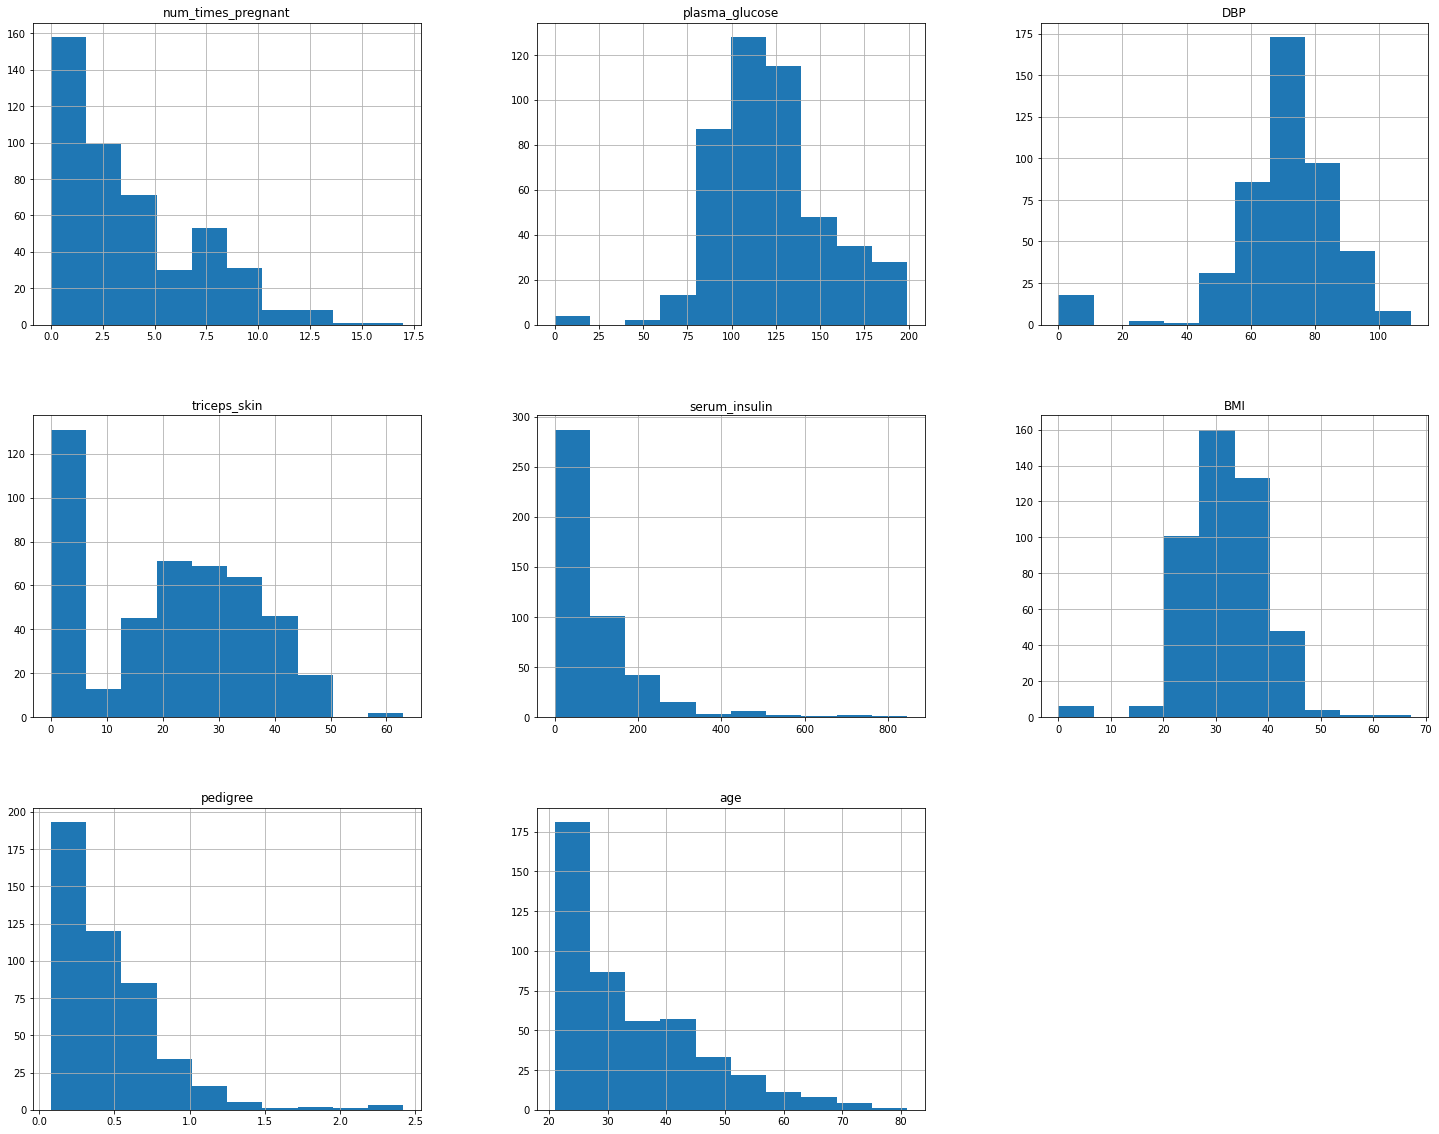

In [6]:
X_train.hist(figsize=(25, 20))

## Build AutoML Model
Use AutoML to get a sense of which algorithm works best

In [10]:
from flaml import AutoML
automl_clf = AutoML()
automl_clf.fit(X_train, y_train, task="classification", time_budget=500, verbose=3)

[flaml.automl: 01-18 09:56:31] {1926} INFO - task = classification
[flaml.automl: 01-18 09:56:31] {1928} INFO - Data split method: stratified
[flaml.automl: 01-18 09:56:31] {1932} INFO - Evaluation method: cv
[flaml.automl: 01-18 09:56:31] {1999} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 01-18 09:56:31] {2051} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 01-18 09:56:31] {2291} INFO - iteration 0, current learner lgbm
[flaml.automl: 01-18 09:56:32] {2404} INFO - Estimated sufficient time budget=9494s. Estimated necessary time budget=233s.
[flaml.automl: 01-18 09:56:32] {2479} INFO -  at 1.1s,	estimator lgbm's best error=0.1770,	best estimator lgbm's best error=0.1770
[flaml.automl: 01-18 09:56:32] {2291} INFO - iteration 1, current learner lgbm
[flaml.automl: 01-18 09:56:32] {2479} INFO -  at 1.2s,	estimator lgbm's best error=0.1770,	best estimator lgbm's best error=0.1770
[flaml.aut

[flaml.automl: 01-18 09:56:34] {2479} INFO -  at 2.8s,	estimator lgbm's best error=0.1563,	best estimator lgbm's best error=0.1563
[flaml.automl: 01-18 09:56:34] {2291} INFO - iteration 37, current learner lgbm
[flaml.automl: 01-18 09:56:34] {2479} INFO -  at 2.8s,	estimator lgbm's best error=0.1563,	best estimator lgbm's best error=0.1563
[flaml.automl: 01-18 09:56:34] {2291} INFO - iteration 38, current learner lgbm
[flaml.automl: 01-18 09:56:34] {2479} INFO -  at 2.9s,	estimator lgbm's best error=0.1563,	best estimator lgbm's best error=0.1563
[flaml.automl: 01-18 09:56:34] {2291} INFO - iteration 39, current learner lgbm
[flaml.automl: 01-18 09:56:34] {2479} INFO -  at 2.9s,	estimator lgbm's best error=0.1563,	best estimator lgbm's best error=0.1563
[flaml.automl: 01-18 09:56:34] {2291} INFO - iteration 40, current learner xgboost
[flaml.automl: 01-18 09:56:34] {2479} INFO -  at 3.0s,	estimator xgboost's best error=0.1674,	best estimator lgbm's best error=0.1563
[flaml.automl: 01-1

[flaml.automl: 01-18 09:56:37] {2479} INFO -  at 6.2s,	estimator lgbm's best error=0.1563,	best estimator lgbm's best error=0.1563
[flaml.automl: 01-18 09:56:37] {2291} INFO - iteration 76, current learner lgbm
[flaml.automl: 01-18 09:56:38] {2479} INFO -  at 6.2s,	estimator lgbm's best error=0.1563,	best estimator lgbm's best error=0.1563
[flaml.automl: 01-18 09:56:38] {2291} INFO - iteration 77, current learner rf
[flaml.automl: 01-18 09:56:38] {2479} INFO -  at 6.3s,	estimator rf's best error=0.1706,	best estimator lgbm's best error=0.1563
[flaml.automl: 01-18 09:56:38] {2291} INFO - iteration 78, current learner rf
[flaml.automl: 01-18 09:56:38] {2479} INFO -  at 6.5s,	estimator rf's best error=0.1706,	best estimator lgbm's best error=0.1563
[flaml.automl: 01-18 09:56:38] {2291} INFO - iteration 79, current learner lgbm
[flaml.automl: 01-18 09:56:38] {2479} INFO -  at 6.5s,	estimator lgbm's best error=0.1563,	best estimator lgbm's best error=0.1563
[flaml.automl: 01-18 09:56:38] {2

[flaml.automl: 01-18 09:56:41] {2479} INFO -  at 9.5s,	estimator extra_tree's best error=0.1821,	best estimator lgbm's best error=0.1563
[flaml.automl: 01-18 09:56:41] {2291} INFO - iteration 115, current learner lgbm
[flaml.automl: 01-18 09:56:41] {2479} INFO -  at 9.6s,	estimator lgbm's best error=0.1563,	best estimator lgbm's best error=0.1563
[flaml.automl: 01-18 09:56:41] {2291} INFO - iteration 116, current learner extra_tree
[flaml.automl: 01-18 09:56:41] {2479} INFO -  at 9.7s,	estimator extra_tree's best error=0.1821,	best estimator lgbm's best error=0.1563
[flaml.automl: 01-18 09:56:41] {2291} INFO - iteration 117, current learner extra_tree
[flaml.automl: 01-18 09:56:41] {2479} INFO -  at 9.8s,	estimator extra_tree's best error=0.1821,	best estimator lgbm's best error=0.1563
[flaml.automl: 01-18 09:56:41] {2291} INFO - iteration 118, current learner lgbm
[flaml.automl: 01-18 09:56:41] {2479} INFO -  at 9.8s,	estimator lgbm's best error=0.1563,	best estimator lgbm's best erro

[flaml.automl: 01-18 09:56:44] {2479} INFO -  at 12.8s,	estimator rf's best error=0.1706,	best estimator lgbm's best error=0.1563
[flaml.automl: 01-18 09:56:44] {2291} INFO - iteration 153, current learner lgbm
[flaml.automl: 01-18 09:56:44] {2479} INFO -  at 12.8s,	estimator lgbm's best error=0.1563,	best estimator lgbm's best error=0.1563
[flaml.automl: 01-18 09:56:44] {2291} INFO - iteration 154, current learner lgbm
[flaml.automl: 01-18 09:56:44] {2479} INFO -  at 12.9s,	estimator lgbm's best error=0.1563,	best estimator lgbm's best error=0.1563
[flaml.automl: 01-18 09:56:44] {2291} INFO - iteration 155, current learner extra_tree
[flaml.automl: 01-18 09:56:44] {2479} INFO -  at 13.0s,	estimator extra_tree's best error=0.1708,	best estimator lgbm's best error=0.1563
[flaml.automl: 01-18 09:56:44] {2291} INFO - iteration 156, current learner rf
[flaml.automl: 01-18 09:56:44] {2479} INFO -  at 13.1s,	estimator rf's best error=0.1706,	best estimator lgbm's best error=0.1563
[flaml.aut

[flaml.automl: 01-18 09:56:49] {2291} INFO - iteration 191, current learner rf
[flaml.automl: 01-18 09:56:49] {2479} INFO -  at 17.4s,	estimator rf's best error=0.1572,	best estimator lgbm's best error=0.1563
[flaml.automl: 01-18 09:56:49] {2291} INFO - iteration 192, current learner rf
[flaml.automl: 01-18 09:56:49] {2479} INFO -  at 17.5s,	estimator rf's best error=0.1572,	best estimator lgbm's best error=0.1563
[flaml.automl: 01-18 09:56:49] {2291} INFO - iteration 193, current learner extra_tree
[flaml.automl: 01-18 09:56:49] {2479} INFO -  at 17.6s,	estimator extra_tree's best error=0.1708,	best estimator lgbm's best error=0.1563
[flaml.automl: 01-18 09:56:49] {2291} INFO - iteration 194, current learner lgbm
[flaml.automl: 01-18 09:56:49] {2479} INFO -  at 17.7s,	estimator lgbm's best error=0.1563,	best estimator lgbm's best error=0.1563
[flaml.automl: 01-18 09:56:49] {2291} INFO - iteration 195, current learner lgbm
[flaml.automl: 01-18 09:56:49] {2479} INFO -  at 17.7s,	estimat

[flaml.automl: 01-18 09:56:53] {2479} INFO -  at 22.1s,	estimator extra_tree's best error=0.1708,	best estimator lgbm's best error=0.1563
[flaml.automl: 01-18 09:56:53] {2291} INFO - iteration 230, current learner rf
[flaml.automl: 01-18 09:56:54] {2479} INFO -  at 22.2s,	estimator rf's best error=0.1572,	best estimator lgbm's best error=0.1563
[flaml.automl: 01-18 09:56:54] {2291} INFO - iteration 231, current learner extra_tree
[flaml.automl: 01-18 09:56:54] {2479} INFO -  at 22.4s,	estimator extra_tree's best error=0.1708,	best estimator lgbm's best error=0.1563
[flaml.automl: 01-18 09:56:54] {2291} INFO - iteration 232, current learner xgboost
[flaml.automl: 01-18 09:56:54] {2479} INFO -  at 22.4s,	estimator xgboost's best error=0.1651,	best estimator lgbm's best error=0.1563
[flaml.automl: 01-18 09:56:54] {2291} INFO - iteration 233, current learner extra_tree
[flaml.automl: 01-18 09:56:54] {2479} INFO -  at 22.5s,	estimator extra_tree's best error=0.1708,	best estimator lgbm's be

[flaml.automl: 01-18 09:56:58] {2291} INFO - iteration 268, current learner xgboost
[flaml.automl: 01-18 09:56:58] {2479} INFO -  at 26.3s,	estimator xgboost's best error=0.1576,	best estimator lgbm's best error=0.1563
[flaml.automl: 01-18 09:56:58] {2291} INFO - iteration 269, current learner xgboost
[flaml.automl: 01-18 09:56:58] {2479} INFO -  at 26.4s,	estimator xgboost's best error=0.1576,	best estimator lgbm's best error=0.1563
[flaml.automl: 01-18 09:56:58] {2291} INFO - iteration 270, current learner xgboost
[flaml.automl: 01-18 09:56:58] {2479} INFO -  at 26.5s,	estimator xgboost's best error=0.1576,	best estimator lgbm's best error=0.1563
[flaml.automl: 01-18 09:56:58] {2291} INFO - iteration 271, current learner xgboost
[flaml.automl: 01-18 09:56:58] {2479} INFO -  at 26.6s,	estimator xgboost's best error=0.1576,	best estimator lgbm's best error=0.1563
[flaml.automl: 01-18 09:56:58] {2291} INFO - iteration 272, current learner xgboost
[flaml.automl: 01-18 09:56:58] {2479} IN

[flaml.automl: 01-18 09:57:01] {2479} INFO -  at 29.6s,	estimator xgboost's best error=0.1552,	best estimator xgboost's best error=0.1552
[flaml.automl: 01-18 09:57:01] {2291} INFO - iteration 306, current learner xgboost
[flaml.automl: 01-18 09:57:01] {2479} INFO -  at 29.7s,	estimator xgboost's best error=0.1552,	best estimator xgboost's best error=0.1552
[flaml.automl: 01-18 09:57:01] {2291} INFO - iteration 307, current learner xgboost
[flaml.automl: 01-18 09:57:01] {2479} INFO -  at 29.8s,	estimator xgboost's best error=0.1552,	best estimator xgboost's best error=0.1552
[flaml.automl: 01-18 09:57:01] {2291} INFO - iteration 308, current learner lgbm
[flaml.automl: 01-18 09:57:01] {2479} INFO -  at 29.8s,	estimator lgbm's best error=0.1563,	best estimator xgboost's best error=0.1552
[flaml.automl: 01-18 09:57:01] {2291} INFO - iteration 309, current learner xgboost
[flaml.automl: 01-18 09:57:01] {2479} INFO -  at 29.9s,	estimator xgboost's best error=0.1552,	best estimator xgboost'

[flaml.automl: 01-18 09:57:05] {2291} INFO - iteration 343, current learner xgboost
[flaml.automl: 01-18 09:57:05] {2479} INFO -  at 33.6s,	estimator xgboost's best error=0.1552,	best estimator xgboost's best error=0.1552
[flaml.automl: 01-18 09:57:05] {2291} INFO - iteration 344, current learner xgboost
[flaml.automl: 01-18 09:57:05] {2479} INFO -  at 33.7s,	estimator xgboost's best error=0.1552,	best estimator xgboost's best error=0.1552
[flaml.automl: 01-18 09:57:05] {2291} INFO - iteration 345, current learner extra_tree
[flaml.automl: 01-18 09:57:05] {2479} INFO -  at 33.8s,	estimator extra_tree's best error=0.1708,	best estimator xgboost's best error=0.1552
[flaml.automl: 01-18 09:57:05] {2291} INFO - iteration 346, current learner xgboost
[flaml.automl: 01-18 09:57:05] {2479} INFO -  at 33.9s,	estimator xgboost's best error=0.1552,	best estimator xgboost's best error=0.1552
[flaml.automl: 01-18 09:57:05] {2291} INFO - iteration 347, current learner xgboost
[flaml.automl: 01-18 0

[flaml.automl: 01-18 09:57:09] {2479} INFO -  at 37.7s,	estimator xgboost's best error=0.1541,	best estimator xgboost's best error=0.1541
[flaml.automl: 01-18 09:57:09] {2291} INFO - iteration 381, current learner xgboost
[flaml.automl: 01-18 09:57:09] {2479} INFO -  at 37.9s,	estimator xgboost's best error=0.1541,	best estimator xgboost's best error=0.1541
[flaml.automl: 01-18 09:57:09] {2291} INFO - iteration 382, current learner xgboost
[flaml.automl: 01-18 09:57:09] {2479} INFO -  at 38.0s,	estimator xgboost's best error=0.1541,	best estimator xgboost's best error=0.1541
[flaml.automl: 01-18 09:57:09] {2291} INFO - iteration 383, current learner rf
[flaml.automl: 01-18 09:57:09] {2479} INFO -  at 38.1s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1541
[flaml.automl: 01-18 09:57:09] {2291} INFO - iteration 384, current learner xgboost
[flaml.automl: 01-18 09:57:10] {2479} INFO -  at 38.2s,	estimator xgboost's best error=0.1541,	best estimator xgboost's be

[flaml.automl: 01-18 09:57:13] {2291} INFO - iteration 418, current learner xgboost
[flaml.automl: 01-18 09:57:14] {2479} INFO -  at 42.3s,	estimator xgboost's best error=0.1541,	best estimator xgboost's best error=0.1541
[flaml.automl: 01-18 09:57:14] {2291} INFO - iteration 419, current learner rf
[flaml.automl: 01-18 09:57:14] {2479} INFO -  at 42.4s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1541
[flaml.automl: 01-18 09:57:14] {2291} INFO - iteration 420, current learner xgboost
[flaml.automl: 01-18 09:57:14] {2479} INFO -  at 42.5s,	estimator xgboost's best error=0.1541,	best estimator xgboost's best error=0.1541
[flaml.automl: 01-18 09:57:14] {2291} INFO - iteration 421, current learner rf
[flaml.automl: 01-18 09:57:14] {2479} INFO -  at 42.9s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1541
[flaml.automl: 01-18 09:57:14] {2291} INFO - iteration 422, current learner xgboost
[flaml.automl: 01-18 09:57:14] {2479} INFO -  at

[flaml.automl: 01-18 09:57:17] {2291} INFO - iteration 456, current learner extra_tree
[flaml.automl: 01-18 09:57:17] {2479} INFO -  at 46.0s,	estimator extra_tree's best error=0.1708,	best estimator xgboost's best error=0.1541
[flaml.automl: 01-18 09:57:17] {2291} INFO - iteration 457, current learner extra_tree
[flaml.automl: 01-18 09:57:17] {2479} INFO -  at 46.1s,	estimator extra_tree's best error=0.1708,	best estimator xgboost's best error=0.1541
[flaml.automl: 01-18 09:57:17] {2291} INFO - iteration 458, current learner xgboost
[flaml.automl: 01-18 09:57:18] {2479} INFO -  at 46.3s,	estimator xgboost's best error=0.1541,	best estimator xgboost's best error=0.1541
[flaml.automl: 01-18 09:57:18] {2291} INFO - iteration 459, current learner xgboost
[flaml.automl: 01-18 09:57:18] {2479} INFO -  at 46.4s,	estimator xgboost's best error=0.1541,	best estimator xgboost's best error=0.1541
[flaml.automl: 01-18 09:57:18] {2291} INFO - iteration 460, current learner extra_tree
[flaml.automl

[flaml.automl: 01-18 09:57:21] {2479} INFO -  at 50.2s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1541
[flaml.automl: 01-18 09:57:21] {2291} INFO - iteration 494, current learner xgboost
[flaml.automl: 01-18 09:57:22] {2479} INFO -  at 50.3s,	estimator xgboost's best error=0.1541,	best estimator xgboost's best error=0.1541
[flaml.automl: 01-18 09:57:22] {2291} INFO - iteration 495, current learner extra_tree
[flaml.automl: 01-18 09:57:22] {2479} INFO -  at 50.5s,	estimator extra_tree's best error=0.1708,	best estimator xgboost's best error=0.1541
[flaml.automl: 01-18 09:57:22] {2291} INFO - iteration 496, current learner rf
[flaml.automl: 01-18 09:57:22] {2479} INFO -  at 50.6s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1541
[flaml.automl: 01-18 09:57:22] {2291} INFO - iteration 497, current learner lgbm
[flaml.automl: 01-18 09:57:22] {2479} INFO -  at 50.6s,	estimator lgbm's best error=0.1563,	best estimator xgboost's best er

[flaml.automl: 01-18 09:57:25] {2291} INFO - iteration 531, current learner lgbm
[flaml.automl: 01-18 09:57:25] {2479} INFO -  at 54.1s,	estimator lgbm's best error=0.1563,	best estimator xgboost's best error=0.1541
[flaml.automl: 01-18 09:57:25] {2291} INFO - iteration 532, current learner rf
[flaml.automl: 01-18 09:57:26] {2479} INFO -  at 54.5s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1541
[flaml.automl: 01-18 09:57:26] {2291} INFO - iteration 533, current learner rf
[flaml.automl: 01-18 09:57:26] {2479} INFO -  at 54.6s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1541
[flaml.automl: 01-18 09:57:26] {2291} INFO - iteration 534, current learner extra_tree
[flaml.automl: 01-18 09:57:26] {2479} INFO -  at 54.7s,	estimator extra_tree's best error=0.1619,	best estimator xgboost's best error=0.1541
[flaml.automl: 01-18 09:57:26] {2291} INFO - iteration 535, current learner lgbm
[flaml.automl: 01-18 09:57:26] {2479} INFO -  at 54

[flaml.automl: 01-18 09:57:30] {2479} INFO -  at 58.4s,	estimator xgboost's best error=0.1523,	best estimator xgboost's best error=0.1523
[flaml.automl: 01-18 09:57:30] {2291} INFO - iteration 569, current learner xgboost
[flaml.automl: 01-18 09:57:30] {2479} INFO -  at 58.6s,	estimator xgboost's best error=0.1523,	best estimator xgboost's best error=0.1523
[flaml.automl: 01-18 09:57:30] {2291} INFO - iteration 570, current learner xgboost
[flaml.automl: 01-18 09:57:30] {2479} INFO -  at 58.6s,	estimator xgboost's best error=0.1523,	best estimator xgboost's best error=0.1523
[flaml.automl: 01-18 09:57:30] {2291} INFO - iteration 571, current learner xgboost
[flaml.automl: 01-18 09:57:30] {2479} INFO -  at 58.7s,	estimator xgboost's best error=0.1523,	best estimator xgboost's best error=0.1523
[flaml.automl: 01-18 09:57:30] {2291} INFO - iteration 572, current learner xgboost
[flaml.automl: 01-18 09:57:30] {2479} INFO -  at 58.8s,	estimator xgboost's best error=0.1523,	best estimator xg

[flaml.automl: 01-18 09:57:33] {2291} INFO - iteration 606, current learner lgbm
[flaml.automl: 01-18 09:57:33] {2479} INFO -  at 61.7s,	estimator lgbm's best error=0.1563,	best estimator xgboost's best error=0.1523
[flaml.automl: 01-18 09:57:33] {2291} INFO - iteration 607, current learner xgboost
[flaml.automl: 01-18 09:57:33] {2479} INFO -  at 61.8s,	estimator xgboost's best error=0.1523,	best estimator xgboost's best error=0.1523
[flaml.automl: 01-18 09:57:33] {2291} INFO - iteration 608, current learner rf
[flaml.automl: 01-18 09:57:33] {2479} INFO -  at 62.0s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1523
[flaml.automl: 01-18 09:57:33] {2291} INFO - iteration 609, current learner extra_tree
[flaml.automl: 01-18 09:57:33] {2479} INFO -  at 62.1s,	estimator extra_tree's best error=0.1619,	best estimator xgboost's best error=0.1523
[flaml.automl: 01-18 09:57:33] {2291} INFO - iteration 610, current learner xgboost
[flaml.automl: 01-18 09:57:33] {2479} 

[flaml.automl: 01-18 09:57:37] {2479} INFO -  at 66.0s,	estimator xgboost's best error=0.1523,	best estimator xgboost's best error=0.1523
[flaml.automl: 01-18 09:57:37] {2291} INFO - iteration 644, current learner lgbm
[flaml.automl: 01-18 09:57:37] {2479} INFO -  at 66.0s,	estimator lgbm's best error=0.1563,	best estimator xgboost's best error=0.1523
[flaml.automl: 01-18 09:57:37] {2291} INFO - iteration 645, current learner extra_tree
[flaml.automl: 01-18 09:57:37] {2479} INFO -  at 66.1s,	estimator extra_tree's best error=0.1619,	best estimator xgboost's best error=0.1523
[flaml.automl: 01-18 09:57:37] {2291} INFO - iteration 646, current learner xgboost
[flaml.automl: 01-18 09:57:38] {2479} INFO -  at 66.2s,	estimator xgboost's best error=0.1523,	best estimator xgboost's best error=0.1523
[flaml.automl: 01-18 09:57:38] {2291} INFO - iteration 647, current learner xgboost
[flaml.automl: 01-18 09:57:38] {2479} INFO -  at 66.3s,	estimator xgboost's best error=0.1523,	best estimator xg

[flaml.automl: 01-18 09:57:41] {2291} INFO - iteration 681, current learner lgbm
[flaml.automl: 01-18 09:57:41] {2479} INFO -  at 70.1s,	estimator lgbm's best error=0.1563,	best estimator xgboost's best error=0.1523
[flaml.automl: 01-18 09:57:41] {2291} INFO - iteration 682, current learner extra_tree
[flaml.automl: 01-18 09:57:42] {2479} INFO -  at 70.3s,	estimator extra_tree's best error=0.1619,	best estimator xgboost's best error=0.1523
[flaml.automl: 01-18 09:57:42] {2291} INFO - iteration 683, current learner extra_tree
[flaml.automl: 01-18 09:57:42] {2479} INFO -  at 70.4s,	estimator extra_tree's best error=0.1619,	best estimator xgboost's best error=0.1523
[flaml.automl: 01-18 09:57:42] {2291} INFO - iteration 684, current learner xgboost
[flaml.automl: 01-18 09:57:42] {2479} INFO -  at 70.5s,	estimator xgboost's best error=0.1523,	best estimator xgboost's best error=0.1523
[flaml.automl: 01-18 09:57:42] {2291} INFO - iteration 685, current learner xgboost
[flaml.automl: 01-18 0

[flaml.automl: 01-18 09:57:45] {2479} INFO -  at 74.0s,	estimator extra_tree's best error=0.1619,	best estimator xgboost's best error=0.1523
[flaml.automl: 01-18 09:57:45] {2291} INFO - iteration 719, current learner xgboost
[flaml.automl: 01-18 09:57:45] {2479} INFO -  at 74.1s,	estimator xgboost's best error=0.1523,	best estimator xgboost's best error=0.1523
[flaml.automl: 01-18 09:57:45] {2291} INFO - iteration 720, current learner xgboost
[flaml.automl: 01-18 09:57:45] {2479} INFO -  at 74.2s,	estimator xgboost's best error=0.1523,	best estimator xgboost's best error=0.1523
[flaml.automl: 01-18 09:57:45] {2291} INFO - iteration 721, current learner xgboost
[flaml.automl: 01-18 09:57:46] {2479} INFO -  at 74.3s,	estimator xgboost's best error=0.1523,	best estimator xgboost's best error=0.1523
[flaml.automl: 01-18 09:57:46] {2291} INFO - iteration 722, current learner xgboost
[flaml.automl: 01-18 09:57:46] {2479} INFO -  at 74.3s,	estimator xgboost's best error=0.1523,	best estimator

[flaml.automl: 01-18 09:57:49] {2479} INFO -  at 77.4s,	estimator lgbm's best error=0.1563,	best estimator xgboost's best error=0.1523
[flaml.automl: 01-18 09:57:49] {2291} INFO - iteration 756, current learner extra_tree
[flaml.automl: 01-18 09:57:49] {2479} INFO -  at 77.5s,	estimator extra_tree's best error=0.1619,	best estimator xgboost's best error=0.1523
[flaml.automl: 01-18 09:57:49] {2291} INFO - iteration 757, current learner extra_tree
[flaml.automl: 01-18 09:57:49] {2479} INFO -  at 77.6s,	estimator extra_tree's best error=0.1619,	best estimator xgboost's best error=0.1523
[flaml.automl: 01-18 09:57:49] {2291} INFO - iteration 758, current learner xgboost
[flaml.automl: 01-18 09:57:49] {2479} INFO -  at 77.7s,	estimator xgboost's best error=0.1523,	best estimator xgboost's best error=0.1523
[flaml.automl: 01-18 09:57:49] {2291} INFO - iteration 759, current learner extra_tree
[flaml.automl: 01-18 09:57:49] {2479} INFO -  at 77.8s,	estimator extra_tree's best error=0.1619,	be

[flaml.automl: 01-18 09:57:52] {2291} INFO - iteration 793, current learner xgboost
[flaml.automl: 01-18 09:57:53] {2479} INFO -  at 81.2s,	estimator xgboost's best error=0.1523,	best estimator xgboost's best error=0.1523
[flaml.automl: 01-18 09:57:53] {2291} INFO - iteration 794, current learner xgboost
[flaml.automl: 01-18 09:57:53] {2479} INFO -  at 81.3s,	estimator xgboost's best error=0.1523,	best estimator xgboost's best error=0.1523
[flaml.automl: 01-18 09:57:53] {2291} INFO - iteration 795, current learner rf
[flaml.automl: 01-18 09:57:53] {2479} INFO -  at 81.4s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1523
[flaml.automl: 01-18 09:57:53] {2291} INFO - iteration 796, current learner rf
[flaml.automl: 01-18 09:57:53] {2479} INFO -  at 81.5s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1523
[flaml.automl: 01-18 09:57:53] {2291} INFO - iteration 797, current learner xgboost
[flaml.automl: 01-18 09:57:53] {2479} INFO -  at

[flaml.automl: 01-18 09:57:56] {2291} INFO - iteration 831, current learner lgbm
[flaml.automl: 01-18 09:57:57] {2479} INFO -  at 85.2s,	estimator lgbm's best error=0.1563,	best estimator xgboost's best error=0.1523
[flaml.automl: 01-18 09:57:57] {2291} INFO - iteration 832, current learner xgboost
[flaml.automl: 01-18 09:57:57] {2479} INFO -  at 85.3s,	estimator xgboost's best error=0.1523,	best estimator xgboost's best error=0.1523
[flaml.automl: 01-18 09:57:57] {2291} INFO - iteration 833, current learner xgboost
[flaml.automl: 01-18 09:57:57] {2479} INFO -  at 85.4s,	estimator xgboost's best error=0.1523,	best estimator xgboost's best error=0.1523
[flaml.automl: 01-18 09:57:57] {2291} INFO - iteration 834, current learner xgboost
[flaml.automl: 01-18 09:57:57] {2479} INFO -  at 85.5s,	estimator xgboost's best error=0.1523,	best estimator xgboost's best error=0.1523
[flaml.automl: 01-18 09:57:57] {2291} INFO - iteration 835, current learner xgboost
[flaml.automl: 01-18 09:57:57] {24

[flaml.automl: 01-18 09:58:00] {2479} INFO -  at 88.9s,	estimator extra_tree's best error=0.1619,	best estimator xgboost's best error=0.1513
[flaml.automl: 01-18 09:58:00] {2291} INFO - iteration 869, current learner xgboost
[flaml.automl: 01-18 09:58:00] {2479} INFO -  at 89.0s,	estimator xgboost's best error=0.1513,	best estimator xgboost's best error=0.1513
[flaml.automl: 01-18 09:58:00] {2291} INFO - iteration 870, current learner xgboost
[flaml.automl: 01-18 09:58:00] {2479} INFO -  at 89.1s,	estimator xgboost's best error=0.1513,	best estimator xgboost's best error=0.1513
[flaml.automl: 01-18 09:58:00] {2291} INFO - iteration 871, current learner extra_tree
[flaml.automl: 01-18 09:58:01] {2479} INFO -  at 89.2s,	estimator extra_tree's best error=0.1619,	best estimator xgboost's best error=0.1513
[flaml.automl: 01-18 09:58:01] {2291} INFO - iteration 872, current learner lgbm
[flaml.automl: 01-18 09:58:01] {2479} INFO -  at 89.2s,	estimator lgbm's best error=0.1563,	best estimator

[flaml.automl: 01-18 09:58:05] {2291} INFO - iteration 906, current learner lgbm
[flaml.automl: 01-18 09:58:05] {2479} INFO -  at 93.7s,	estimator lgbm's best error=0.1563,	best estimator xgboost's best error=0.1513
[flaml.automl: 01-18 09:58:05] {2291} INFO - iteration 907, current learner extra_tree
[flaml.automl: 01-18 09:58:05] {2479} INFO -  at 93.8s,	estimator extra_tree's best error=0.1619,	best estimator xgboost's best error=0.1513
[flaml.automl: 01-18 09:58:05] {2291} INFO - iteration 908, current learner xgboost
[flaml.automl: 01-18 09:58:05] {2479} INFO -  at 93.9s,	estimator xgboost's best error=0.1513,	best estimator xgboost's best error=0.1513
[flaml.automl: 01-18 09:58:05] {2291} INFO - iteration 909, current learner xgboost
[flaml.automl: 01-18 09:58:05] {2479} INFO -  at 94.0s,	estimator xgboost's best error=0.1513,	best estimator xgboost's best error=0.1513
[flaml.automl: 01-18 09:58:05] {2291} INFO - iteration 910, current learner extra_tree
[flaml.automl: 01-18 09:5

[flaml.automl: 01-18 09:58:09] {2479} INFO -  at 97.8s,	estimator xgboost's best error=0.1513,	best estimator xgboost's best error=0.1513
[flaml.automl: 01-18 09:58:09] {2291} INFO - iteration 944, current learner lgbm
[flaml.automl: 01-18 09:58:09] {2479} INFO -  at 97.9s,	estimator lgbm's best error=0.1563,	best estimator xgboost's best error=0.1513
[flaml.automl: 01-18 09:58:09] {2291} INFO - iteration 945, current learner lgbm
[flaml.automl: 01-18 09:58:09] {2479} INFO -  at 97.9s,	estimator lgbm's best error=0.1563,	best estimator xgboost's best error=0.1513
[flaml.automl: 01-18 09:58:09] {2291} INFO - iteration 946, current learner xgboost
[flaml.automl: 01-18 09:58:09] {2479} INFO -  at 98.1s,	estimator xgboost's best error=0.1513,	best estimator xgboost's best error=0.1513
[flaml.automl: 01-18 09:58:09] {2291} INFO - iteration 947, current learner xgboost
[flaml.automl: 01-18 09:58:09] {2479} INFO -  at 98.2s,	estimator xgboost's best error=0.1513,	best estimator xgboost's best

[flaml.automl: 01-18 09:58:13] {2291} INFO - iteration 981, current learner xgboost
[flaml.automl: 01-18 09:58:13] {2479} INFO -  at 102.2s,	estimator xgboost's best error=0.1513,	best estimator xgboost's best error=0.1513
[flaml.automl: 01-18 09:58:13] {2291} INFO - iteration 982, current learner rf
[flaml.automl: 01-18 09:58:14] {2479} INFO -  at 102.3s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1513
[flaml.automl: 01-18 09:58:14] {2291} INFO - iteration 983, current learner xgboost
[flaml.automl: 01-18 09:58:14] {2479} INFO -  at 102.4s,	estimator xgboost's best error=0.1513,	best estimator xgboost's best error=0.1513
[flaml.automl: 01-18 09:58:14] {2291} INFO - iteration 984, current learner lgbm
[flaml.automl: 01-18 09:58:14] {2479} INFO -  at 102.5s,	estimator lgbm's best error=0.1563,	best estimator xgboost's best error=0.1513
[flaml.automl: 01-18 09:58:14] {2291} INFO - iteration 985, current learner lgbm
[flaml.automl: 01-18 09:58:14] {2479} INFO 

[flaml.automl: 01-18 09:58:18] {2291} INFO - iteration 1018, current learner lgbm
[flaml.automl: 01-18 09:58:18] {2479} INFO -  at 106.2s,	estimator lgbm's best error=0.1563,	best estimator xgboost's best error=0.1513
[flaml.automl: 01-18 09:58:18] {2291} INFO - iteration 1019, current learner lgbm
[flaml.automl: 01-18 09:58:18] {2479} INFO -  at 106.3s,	estimator lgbm's best error=0.1563,	best estimator xgboost's best error=0.1513
[flaml.automl: 01-18 09:58:18] {2291} INFO - iteration 1020, current learner rf
[flaml.automl: 01-18 09:58:18] {2479} INFO -  at 106.4s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1513
[flaml.automl: 01-18 09:58:18] {2291} INFO - iteration 1021, current learner xgboost
[flaml.automl: 01-18 09:58:18] {2479} INFO -  at 106.5s,	estimator xgboost's best error=0.1513,	best estimator xgboost's best error=0.1513
[flaml.automl: 01-18 09:58:18] {2291} INFO - iteration 1022, current learner lgbm
[flaml.automl: 01-18 09:58:18] {2479} INFO -

[flaml.automl: 01-18 09:58:21] {2291} INFO - iteration 1055, current learner extra_tree
[flaml.automl: 01-18 09:58:22] {2479} INFO -  at 110.2s,	estimator extra_tree's best error=0.1575,	best estimator xgboost's best error=0.1486
[flaml.automl: 01-18 09:58:22] {2291} INFO - iteration 1056, current learner xgboost
[flaml.automl: 01-18 09:58:22] {2479} INFO -  at 110.4s,	estimator xgboost's best error=0.1486,	best estimator xgboost's best error=0.1486
[flaml.automl: 01-18 09:58:22] {2291} INFO - iteration 1057, current learner lgbm
[flaml.automl: 01-18 09:58:22] {2479} INFO -  at 110.4s,	estimator lgbm's best error=0.1563,	best estimator xgboost's best error=0.1486
[flaml.automl: 01-18 09:58:22] {2291} INFO - iteration 1058, current learner extra_tree
[flaml.automl: 01-18 09:58:22] {2479} INFO -  at 110.6s,	estimator extra_tree's best error=0.1575,	best estimator xgboost's best error=0.1486
[flaml.automl: 01-18 09:58:22] {2291} INFO - iteration 1059, current learner xgboost
[flaml.automl

[flaml.automl: 01-18 09:58:27] {2291} INFO - iteration 1092, current learner xgboost
[flaml.automl: 01-18 09:58:27] {2479} INFO -  at 115.4s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:58:27] {2291} INFO - iteration 1093, current learner xgboost
[flaml.automl: 01-18 09:58:27] {2479} INFO -  at 115.6s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:58:27] {2291} INFO - iteration 1094, current learner xgboost
[flaml.automl: 01-18 09:58:27] {2479} INFO -  at 115.9s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:58:27] {2291} INFO - iteration 1095, current learner extra_tree
[flaml.automl: 01-18 09:58:27] {2479} INFO -  at 116.1s,	estimator extra_tree's best error=0.1575,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:58:27] {2291} INFO - iteration 1096, current learner xgboost
[flaml.automl

[flaml.automl: 01-18 09:58:34] {2291} INFO - iteration 1129, current learner extra_tree
[flaml.automl: 01-18 09:58:34] {2479} INFO -  at 122.4s,	estimator extra_tree's best error=0.1575,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:58:34] {2291} INFO - iteration 1130, current learner xgboost
[flaml.automl: 01-18 09:58:34] {2479} INFO -  at 122.5s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:58:34] {2291} INFO - iteration 1131, current learner xgboost
[flaml.automl: 01-18 09:58:34] {2479} INFO -  at 122.9s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:58:34] {2291} INFO - iteration 1132, current learner xgboost
[flaml.automl: 01-18 09:58:34] {2479} INFO -  at 123.0s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:58:34] {2291} INFO - iteration 1133, current learner xgboost
[flaml.automl

[flaml.automl: 01-18 09:58:40] {2291} INFO - iteration 1166, current learner lgbm
[flaml.automl: 01-18 09:58:40] {2479} INFO -  at 129.2s,	estimator lgbm's best error=0.1563,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:58:40] {2291} INFO - iteration 1167, current learner xgboost
[flaml.automl: 01-18 09:58:41] {2479} INFO -  at 129.4s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:58:41] {2291} INFO - iteration 1168, current learner rf
[flaml.automl: 01-18 09:58:41] {2479} INFO -  at 129.5s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:58:41] {2291} INFO - iteration 1169, current learner xgboost
[flaml.automl: 01-18 09:58:41] {2479} INFO -  at 129.6s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:58:41] {2291} INFO - iteration 1170, current learner xgboost
[flaml.automl: 01-18 09:58:41] {247

[flaml.automl: 01-18 09:58:50] {2291} INFO - iteration 1203, current learner xgboost
[flaml.automl: 01-18 09:58:50] {2479} INFO -  at 138.9s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:58:50] {2291} INFO - iteration 1204, current learner xgboost
[flaml.automl: 01-18 09:58:50] {2479} INFO -  at 139.0s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:58:50] {2291} INFO - iteration 1205, current learner xgboost
[flaml.automl: 01-18 09:58:51] {2479} INFO -  at 139.2s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:58:51] {2291} INFO - iteration 1206, current learner xgboost
[flaml.automl: 01-18 09:58:51] {2479} INFO -  at 139.4s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:58:51] {2291} INFO - iteration 1207, current learner extra_tree
[flaml.automl: 0

[flaml.automl: 01-18 09:58:58] {2291} INFO - iteration 1240, current learner rf
[flaml.automl: 01-18 09:58:58] {2479} INFO -  at 146.7s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:58:58] {2291} INFO - iteration 1241, current learner extra_tree
[flaml.automl: 01-18 09:58:58] {2479} INFO -  at 146.9s,	estimator extra_tree's best error=0.1575,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:58:58] {2291} INFO - iteration 1242, current learner xgboost
[flaml.automl: 01-18 09:58:58] {2479} INFO -  at 147.0s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:58:58] {2291} INFO - iteration 1243, current learner catboost
[flaml.automl: 01-18 09:58:59] {2479} INFO -  at 147.4s,	estimator catboost's best error=0.1662,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:58:59] {2291} INFO - iteration 1244, current learner lgbm
[flaml.automl: 01-18 09:

[flaml.automl: 01-18 09:59:05] {2291} INFO - iteration 1277, current learner rf
[flaml.automl: 01-18 09:59:05] {2479} INFO -  at 154.0s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:05] {2291} INFO - iteration 1278, current learner xgboost
[flaml.automl: 01-18 09:59:05] {2479} INFO -  at 154.1s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:05] {2291} INFO - iteration 1279, current learner xgboost
[flaml.automl: 01-18 09:59:06] {2479} INFO -  at 154.3s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:06] {2291} INFO - iteration 1280, current learner catboost
[flaml.automl: 01-18 09:59:06] {2479} INFO -  at 154.7s,	estimator catboost's best error=0.1662,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:06] {2291} INFO - iteration 1281, current learner lgbm
[flaml.automl: 01-18 09:59:06]

[flaml.automl: 01-18 09:59:13] {2291} INFO - iteration 1314, current learner xgboost
[flaml.automl: 01-18 09:59:13] {2479} INFO -  at 161.6s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:13] {2291} INFO - iteration 1315, current learner xgboost
[flaml.automl: 01-18 09:59:13] {2479} INFO -  at 161.7s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:13] {2291} INFO - iteration 1316, current learner lgbm
[flaml.automl: 01-18 09:59:13] {2479} INFO -  at 161.8s,	estimator lgbm's best error=0.1563,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:13] {2291} INFO - iteration 1317, current learner xgboost
[flaml.automl: 01-18 09:59:14] {2479} INFO -  at 162.2s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:14] {2291} INFO - iteration 1318, current learner rf
[flaml.automl: 01-18 09:59:14]

[flaml.automl: 01-18 09:59:20] {2291} INFO - iteration 1351, current learner xgboost
[flaml.automl: 01-18 09:59:20] {2479} INFO -  at 168.6s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:20] {2291} INFO - iteration 1352, current learner extra_tree
[flaml.automl: 01-18 09:59:20] {2479} INFO -  at 168.7s,	estimator extra_tree's best error=0.1575,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:20] {2291} INFO - iteration 1353, current learner xgboost
[flaml.automl: 01-18 09:59:20] {2479} INFO -  at 168.8s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:20] {2291} INFO - iteration 1354, current learner xgboost
[flaml.automl: 01-18 09:59:20] {2479} INFO -  at 169.2s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:20] {2291} INFO - iteration 1355, current learner lgbm
[flaml.automl: 0

[flaml.automl: 01-18 09:59:25] {2291} INFO - iteration 1388, current learner extra_tree
[flaml.automl: 01-18 09:59:25] {2479} INFO -  at 173.9s,	estimator extra_tree's best error=0.1575,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:25] {2291} INFO - iteration 1389, current learner xgboost
[flaml.automl: 01-18 09:59:26] {2479} INFO -  at 174.3s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:26] {2291} INFO - iteration 1390, current learner lgbm
[flaml.automl: 01-18 09:59:26] {2479} INFO -  at 174.3s,	estimator lgbm's best error=0.1563,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:26] {2291} INFO - iteration 1391, current learner xgboost
[flaml.automl: 01-18 09:59:26] {2479} INFO -  at 174.4s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:26] {2291} INFO - iteration 1392, current learner rf
[flaml.automl: 01-18 09:

[flaml.automl: 01-18 09:59:31] {2291} INFO - iteration 1425, current learner lgbm
[flaml.automl: 01-18 09:59:31] {2479} INFO -  at 180.1s,	estimator lgbm's best error=0.1563,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:31] {2291} INFO - iteration 1426, current learner rf
[flaml.automl: 01-18 09:59:32] {2479} INFO -  at 180.2s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:32] {2291} INFO - iteration 1427, current learner lgbm
[flaml.automl: 01-18 09:59:32] {2479} INFO -  at 180.3s,	estimator lgbm's best error=0.1563,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:32] {2291} INFO - iteration 1428, current learner rf
[flaml.automl: 01-18 09:59:32] {2479} INFO -  at 180.4s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:32] {2291} INFO - iteration 1429, current learner rf
[flaml.automl: 01-18 09:59:32] {2479} INFO -  at 180.5s,

[flaml.automl: 01-18 09:59:37] {2291} INFO - iteration 1462, current learner rf
[flaml.automl: 01-18 09:59:37] {2479} INFO -  at 185.8s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:37] {2291} INFO - iteration 1463, current learner xgboost
[flaml.automl: 01-18 09:59:37] {2479} INFO -  at 186.0s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:37] {2291} INFO - iteration 1464, current learner lgbm
[flaml.automl: 01-18 09:59:37] {2479} INFO -  at 186.1s,	estimator lgbm's best error=0.1563,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:37] {2291} INFO - iteration 1465, current learner xgboost
[flaml.automl: 01-18 09:59:38] {2479} INFO -  at 186.3s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:38] {2291} INFO - iteration 1466, current learner extra_tree
[flaml.automl: 01-18 09:59:38] {

[flaml.automl: 01-18 09:59:43] {2479} INFO -  at 192.0s,	estimator extra_tree's best error=0.1575,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:43] {2291} INFO - iteration 1500, current learner xgboost
[flaml.automl: 01-18 09:59:43] {2479} INFO -  at 192.2s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:43] {2291} INFO - iteration 1501, current learner extra_tree
[flaml.automl: 01-18 09:59:44] {2479} INFO -  at 192.3s,	estimator extra_tree's best error=0.1575,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:44] {2291} INFO - iteration 1502, current learner xgboost
[flaml.automl: 01-18 09:59:44] {2479} INFO -  at 192.4s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:44] {2291} INFO - iteration 1503, current learner xgboost
[flaml.automl: 01-18 09:59:44] {2479} INFO -  at 192.9s,	estimator xgboost's best error=0.1473,

[flaml.automl: 01-18 09:59:47] {2291} INFO - iteration 1537, current learner lgbm
[flaml.automl: 01-18 09:59:47] {2479} INFO -  at 196.1s,	estimator lgbm's best error=0.1526,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:47] {2291} INFO - iteration 1538, current learner xgboost
[flaml.automl: 01-18 09:59:48] {2479} INFO -  at 196.3s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:48] {2291} INFO - iteration 1539, current learner lgbm
[flaml.automl: 01-18 09:59:48] {2479} INFO -  at 196.3s,	estimator lgbm's best error=0.1526,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:48] {2291} INFO - iteration 1540, current learner lgbm
[flaml.automl: 01-18 09:59:48] {2479} INFO -  at 196.4s,	estimator lgbm's best error=0.1526,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:48] {2291} INFO - iteration 1541, current learner lgbm
[flaml.automl: 01-18 09:59:48] {2479} IN

[flaml.automl: 01-18 09:59:53] {2479} INFO -  at 201.6s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:53] {2291} INFO - iteration 1575, current learner extra_tree
[flaml.automl: 01-18 09:59:53] {2479} INFO -  at 201.7s,	estimator extra_tree's best error=0.1575,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:53] {2291} INFO - iteration 1576, current learner lgbm
[flaml.automl: 01-18 09:59:53] {2479} INFO -  at 201.8s,	estimator lgbm's best error=0.1526,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:53] {2291} INFO - iteration 1577, current learner lgbm
[flaml.automl: 01-18 09:59:53] {2479} INFO -  at 201.8s,	estimator lgbm's best error=0.1526,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:53] {2291} INFO - iteration 1578, current learner catboost
[flaml.automl: 01-18 09:59:54] {2479} INFO -  at 202.3s,	estimator catboost's best error=0.1662,	best estimator xg

[flaml.automl: 01-18 09:59:58] {2479} INFO -  at 207.0s,	estimator lgbm's best error=0.1526,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:58] {2291} INFO - iteration 1612, current learner extra_tree
[flaml.automl: 01-18 09:59:58] {2479} INFO -  at 207.1s,	estimator extra_tree's best error=0.1575,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:58] {2291} INFO - iteration 1613, current learner lgbm
[flaml.automl: 01-18 09:59:58] {2479} INFO -  at 207.1s,	estimator lgbm's best error=0.1526,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:58] {2291} INFO - iteration 1614, current learner lgbm
[flaml.automl: 01-18 09:59:59] {2479} INFO -  at 207.2s,	estimator lgbm's best error=0.1526,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 09:59:59] {2291} INFO - iteration 1615, current learner extra_tree
[flaml.automl: 01-18 09:59:59] {2479} INFO -  at 207.3s,	estimator extra_tree's best error=0.1575,	best estima

[flaml.automl: 01-18 10:00:04] {2479} INFO -  at 212.8s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:04] {2291} INFO - iteration 1649, current learner xgboost
[flaml.automl: 01-18 10:00:04] {2479} INFO -  at 213.0s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:04] {2291} INFO - iteration 1650, current learner extra_tree
[flaml.automl: 01-18 10:00:04] {2479} INFO -  at 213.1s,	estimator extra_tree's best error=0.1575,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:04] {2291} INFO - iteration 1651, current learner lgbm
[flaml.automl: 01-18 10:00:05] {2479} INFO -  at 213.2s,	estimator lgbm's best error=0.1526,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:05] {2291} INFO - iteration 1652, current learner catboost
[flaml.automl: 01-18 10:00:05] {2479} INFO -  at 213.6s,	estimator catboost's best error=0.1662,	best e

[flaml.automl: 01-18 10:00:10] {2479} INFO -  at 218.5s,	estimator lgbm's best error=0.1526,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:10] {2291} INFO - iteration 1686, current learner lgbm
[flaml.automl: 01-18 10:00:10] {2479} INFO -  at 218.5s,	estimator lgbm's best error=0.1526,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:10] {2291} INFO - iteration 1687, current learner lgbm
[flaml.automl: 01-18 10:00:10] {2479} INFO -  at 218.6s,	estimator lgbm's best error=0.1526,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:10] {2291} INFO - iteration 1688, current learner lgbm
[flaml.automl: 01-18 10:00:10] {2479} INFO -  at 218.6s,	estimator lgbm's best error=0.1526,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:10] {2291} INFO - iteration 1689, current learner lgbm
[flaml.automl: 01-18 10:00:10] {2479} INFO -  at 218.7s,	estimator lgbm's best error=0.1526,	best estimator xgboost's best error

[flaml.automl: 01-18 10:00:15] {2479} INFO -  at 224.0s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:15] {2291} INFO - iteration 1723, current learner catboost
[flaml.automl: 01-18 10:00:16] {2479} INFO -  at 225.1s,	estimator catboost's best error=0.1662,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:16] {2291} INFO - iteration 1724, current learner rf
[flaml.automl: 01-18 10:00:17] {2479} INFO -  at 225.2s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:17] {2291} INFO - iteration 1725, current learner extra_tree
[flaml.automl: 01-18 10:00:17] {2479} INFO -  at 225.4s,	estimator extra_tree's best error=0.1575,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:17] {2291} INFO - iteration 1726, current learner lgbm
[flaml.automl: 01-18 10:00:17] {2479} INFO -  at 225.4s,	estimator lgbm's best error=0.1526,	best estimator x

[flaml.automl: 01-18 10:00:21] {2479} INFO -  at 230.1s,	estimator lgbm's best error=0.1505,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:21] {2291} INFO - iteration 1760, current learner xgboost
[flaml.automl: 01-18 10:00:22] {2479} INFO -  at 230.3s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:22] {2291} INFO - iteration 1761, current learner lgbm
[flaml.automl: 01-18 10:00:22] {2479} INFO -  at 230.3s,	estimator lgbm's best error=0.1505,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:22] {2291} INFO - iteration 1762, current learner lgbm
[flaml.automl: 01-18 10:00:22] {2479} INFO -  at 230.4s,	estimator lgbm's best error=0.1505,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:22] {2291} INFO - iteration 1763, current learner lgbm
[flaml.automl: 01-18 10:00:22] {2479} INFO -  at 230.5s,	estimator lgbm's best error=0.1505,	best estimator xgboost's best

[flaml.automl: 01-18 10:00:27] {2291} INFO - iteration 1797, current learner xgboost
[flaml.automl: 01-18 10:00:27] {2479} INFO -  at 235.7s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:27] {2291} INFO - iteration 1798, current learner xgboost
[flaml.automl: 01-18 10:00:27] {2479} INFO -  at 236.0s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:27] {2291} INFO - iteration 1799, current learner xgboost
[flaml.automl: 01-18 10:00:28] {2479} INFO -  at 236.2s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:28] {2291} INFO - iteration 1800, current learner lgbm
[flaml.automl: 01-18 10:00:28] {2479} INFO -  at 236.3s,	estimator lgbm's best error=0.1505,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:28] {2291} INFO - iteration 1801, current learner lgbm
[flaml.automl: 01-18 10:00:2

[flaml.automl: 01-18 10:00:33] {2479} INFO -  at 241.5s,	estimator extra_tree's best error=0.1575,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:33] {2291} INFO - iteration 1835, current learner rf
[flaml.automl: 01-18 10:00:33] {2479} INFO -  at 241.6s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:33] {2291} INFO - iteration 1836, current learner lgbm
[flaml.automl: 01-18 10:00:33] {2479} INFO -  at 241.7s,	estimator lgbm's best error=0.1505,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:33] {2291} INFO - iteration 1837, current learner xgboost
[flaml.automl: 01-18 10:00:33] {2479} INFO -  at 242.0s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:33] {2291} INFO - iteration 1838, current learner lgbm
[flaml.automl: 01-18 10:00:33] {2479} INFO -  at 242.0s,	estimator lgbm's best error=0.1505,	best estimator xgboost's be

[flaml.automl: 01-18 10:00:40] {2291} INFO - iteration 1872, current learner lgbm
[flaml.automl: 01-18 10:00:40] {2479} INFO -  at 248.9s,	estimator lgbm's best error=0.1505,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:40] {2291} INFO - iteration 1873, current learner lgbm
[flaml.automl: 01-18 10:00:40] {2479} INFO -  at 249.0s,	estimator lgbm's best error=0.1505,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:40] {2291} INFO - iteration 1874, current learner lgbm
[flaml.automl: 01-18 10:00:40] {2479} INFO -  at 249.1s,	estimator lgbm's best error=0.1505,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:40] {2291} INFO - iteration 1875, current learner xgboost
[flaml.automl: 01-18 10:00:41] {2479} INFO -  at 249.3s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:41] {2291} INFO - iteration 1876, current learner catboost
[flaml.automl: 01-18 10:00:42] {2479

[flaml.automl: 01-18 10:00:48] {2479} INFO -  at 257.1s,	estimator lgbm's best error=0.1505,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:48] {2291} INFO - iteration 1910, current learner rf
[flaml.automl: 01-18 10:00:49] {2479} INFO -  at 257.2s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:49] {2291} INFO - iteration 1911, current learner rf
[flaml.automl: 01-18 10:00:49] {2479} INFO -  at 257.4s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:49] {2291} INFO - iteration 1912, current learner lgbm
[flaml.automl: 01-18 10:00:49] {2479} INFO -  at 257.4s,	estimator lgbm's best error=0.1505,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:49] {2291} INFO - iteration 1913, current learner lgbm
[flaml.automl: 01-18 10:00:49] {2479} INFO -  at 257.5s,	estimator lgbm's best error=0.1505,	best estimator xgboost's best error=0.1473


[flaml.automl: 01-18 10:00:54] {2291} INFO - iteration 1947, current learner lgbm
[flaml.automl: 01-18 10:00:54] {2479} INFO -  at 262.5s,	estimator lgbm's best error=0.1505,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:54] {2291} INFO - iteration 1948, current learner lgbm
[flaml.automl: 01-18 10:00:54] {2479} INFO -  at 262.5s,	estimator lgbm's best error=0.1505,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:54] {2291} INFO - iteration 1949, current learner rf
[flaml.automl: 01-18 10:00:54] {2479} INFO -  at 262.6s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:54] {2291} INFO - iteration 1950, current learner lgbm
[flaml.automl: 01-18 10:00:54] {2479} INFO -  at 262.7s,	estimator lgbm's best error=0.1505,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:54] {2291} INFO - iteration 1951, current learner lgbm
[flaml.automl: 01-18 10:00:54] {2479} INFO -  at 2

[flaml.automl: 01-18 10:00:59] {2479} INFO -  at 267.7s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:59] {2291} INFO - iteration 1985, current learner lgbm
[flaml.automl: 01-18 10:00:59] {2479} INFO -  at 267.8s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:59] {2291} INFO - iteration 1986, current learner rf
[flaml.automl: 01-18 10:00:59] {2479} INFO -  at 267.9s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:59] {2291} INFO - iteration 1987, current learner extra_tree
[flaml.automl: 01-18 10:00:59] {2479} INFO -  at 268.0s,	estimator extra_tree's best error=0.1575,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:00:59] {2291} INFO - iteration 1988, current learner extra_tree
[flaml.automl: 01-18 10:00:59] {2479} INFO -  at 268.1s,	estimator extra_tree's best error=0.1575,	best estimator xg

[flaml.automl: 01-18 10:01:04] {2291} INFO - iteration 2022, current learner xgb_limitdepth
[flaml.automl: 01-18 10:01:04] {2479} INFO -  at 272.6s,	estimator xgb_limitdepth's best error=0.1689,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:04] {2291} INFO - iteration 2023, current learner xgb_limitdepth
[flaml.automl: 01-18 10:01:04] {2479} INFO -  at 272.7s,	estimator xgb_limitdepth's best error=0.1689,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:04] {2291} INFO - iteration 2024, current learner xgb_limitdepth
[flaml.automl: 01-18 10:01:04] {2479} INFO -  at 272.8s,	estimator xgb_limitdepth's best error=0.1689,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:04] {2291} INFO - iteration 2025, current learner xgb_limitdepth
[flaml.automl: 01-18 10:01:04] {2479} INFO -  at 272.9s,	estimator xgb_limitdepth's best error=0.1689,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:04] {2291} INFO - ite

[flaml.automl: 01-18 10:01:08] {2479} INFO -  at 276.4s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:08] {2291} INFO - iteration 2058, current learner extra_tree
[flaml.automl: 01-18 10:01:08] {2479} INFO -  at 276.6s,	estimator extra_tree's best error=0.1575,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:08] {2291} INFO - iteration 2059, current learner xgboost
[flaml.automl: 01-18 10:01:08] {2479} INFO -  at 276.7s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:08] {2291} INFO - iteration 2060, current learner xgb_limitdepth
[flaml.automl: 01-18 10:01:08] {2479} INFO -  at 276.8s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:08] {2291} INFO - iteration 2061, current learner extra_tree
[flaml.automl: 01-18 10:01:08] {2479} INFO -  at 276.9s,	estimator extra_t

[flaml.automl: 01-18 10:01:13] {2479} INFO -  at 282.2s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:13] {2291} INFO - iteration 2094, current learner xgb_limitdepth
[flaml.automl: 01-18 10:01:14] {2479} INFO -  at 282.2s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:14] {2291} INFO - iteration 2095, current learner xgb_limitdepth
[flaml.automl: 01-18 10:01:14] {2479} INFO -  at 282.3s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:14] {2291} INFO - iteration 2096, current learner xgboost
[flaml.automl: 01-18 10:01:14] {2479} INFO -  at 282.5s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:14] {2291} INFO - iteration 2097, current learner rf
[flaml.automl: 01-18 10:01:14] {2479} INFO -  at 282.6s,	estimator rf's be

[flaml.automl: 01-18 10:01:19] {2291} INFO - iteration 2129, current learner xgb_limitdepth
[flaml.automl: 01-18 10:01:19] {2479} INFO -  at 287.4s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:19] {2291} INFO - iteration 2130, current learner xgboost
[flaml.automl: 01-18 10:01:19] {2479} INFO -  at 287.6s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:19] {2291} INFO - iteration 2131, current learner extra_tree
[flaml.automl: 01-18 10:01:19] {2479} INFO -  at 287.7s,	estimator extra_tree's best error=0.1575,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:19] {2291} INFO - iteration 2132, current learner xgb_limitdepth
[flaml.automl: 01-18 10:01:19] {2479} INFO -  at 287.8s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:19] {2291} INFO - iteration 2133, current l

[flaml.automl: 01-18 10:01:23] {2291} INFO - iteration 2165, current learner xgb_limitdepth
[flaml.automl: 01-18 10:01:23] {2479} INFO -  at 291.6s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:23] {2291} INFO - iteration 2166, current learner rf
[flaml.automl: 01-18 10:01:23] {2479} INFO -  at 291.8s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:23] {2291} INFO - iteration 2167, current learner lgbm
[flaml.automl: 01-18 10:01:23] {2479} INFO -  at 291.8s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:23] {2291} INFO - iteration 2168, current learner xgboost
[flaml.automl: 01-18 10:01:23] {2479} INFO -  at 292.1s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:23] {2291} INFO - iteration 2169, current learner xgb_limitdepth
[flaml.automl:

[flaml.automl: 01-18 10:01:27] {2479} INFO -  at 295.7s,	estimator extra_tree's best error=0.1575,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:27] {2291} INFO - iteration 2202, current learner lgbm
[flaml.automl: 01-18 10:01:27] {2479} INFO -  at 295.8s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:27] {2291} INFO - iteration 2203, current learner extra_tree
[flaml.automl: 01-18 10:01:27] {2479} INFO -  at 295.9s,	estimator extra_tree's best error=0.1575,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:27] {2291} INFO - iteration 2204, current learner rf
[flaml.automl: 01-18 10:01:27] {2479} INFO -  at 296.0s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:27] {2291} INFO - iteration 2205, current learner xgb_limitdepth
[flaml.automl: 01-18 10:01:27] {2479} INFO -  at 296.1s,	estimator xgb_limitdepth's best error=0.1546,	b

[flaml.automl: 01-18 10:01:31] {2479} INFO -  at 299.5s,	estimator extra_tree's best error=0.1575,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:31] {2291} INFO - iteration 2238, current learner extra_tree
[flaml.automl: 01-18 10:01:31] {2479} INFO -  at 299.7s,	estimator extra_tree's best error=0.1575,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:31] {2291} INFO - iteration 2239, current learner xgb_limitdepth
[flaml.automl: 01-18 10:01:31] {2479} INFO -  at 299.7s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:31] {2291} INFO - iteration 2240, current learner rf
[flaml.automl: 01-18 10:01:31] {2479} INFO -  at 299.9s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:31] {2291} INFO - iteration 2241, current learner xgboost
[flaml.automl: 01-18 10:01:31] {2479} INFO -  at 300.0s,	estimator xgboost's best error=0.1

[flaml.automl: 01-18 10:01:35] {2291} INFO - iteration 2274, current learner rf
[flaml.automl: 01-18 10:01:35] {2479} INFO -  at 304.1s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:35] {2291} INFO - iteration 2275, current learner lgbm
[flaml.automl: 01-18 10:01:36] {2479} INFO -  at 304.2s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:36] {2291} INFO - iteration 2276, current learner rf
[flaml.automl: 01-18 10:01:36] {2479} INFO -  at 304.6s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:36] {2291} INFO - iteration 2277, current learner xgb_limitdepth
[flaml.automl: 01-18 10:01:36] {2479} INFO -  at 304.7s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:36] {2291} INFO - iteration 2278, current learner xgb_limitdepth
[flaml.automl: 01-18 10:

[flaml.automl: 01-18 10:01:39] {2291} INFO - iteration 2310, current learner xgb_limitdepth
[flaml.automl: 01-18 10:01:39] {2479} INFO -  at 308.1s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:39] {2291} INFO - iteration 2311, current learner xgboost
[flaml.automl: 01-18 10:01:40] {2479} INFO -  at 308.2s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:40] {2291} INFO - iteration 2312, current learner xgb_limitdepth
[flaml.automl: 01-18 10:01:40] {2479} INFO -  at 308.3s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:40] {2291} INFO - iteration 2313, current learner xgb_limitdepth
[flaml.automl: 01-18 10:01:40] {2479} INFO -  at 308.4s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:40] {2291} INFO - iteration 2314, c

[flaml.automl: 01-18 10:01:44] {2479} INFO -  at 312.6s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:44] {2291} INFO - iteration 2347, current learner extra_tree
[flaml.automl: 01-18 10:01:44] {2479} INFO -  at 312.8s,	estimator extra_tree's best error=0.1575,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:44] {2291} INFO - iteration 2348, current learner xgb_limitdepth
[flaml.automl: 01-18 10:01:44] {2479} INFO -  at 312.8s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:44] {2291} INFO - iteration 2349, current learner rf
[flaml.automl: 01-18 10:01:44] {2479} INFO -  at 313.0s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:44] {2291} INFO - iteration 2350, current learner xgb_limitdepth
[flaml.automl: 01-18 10:01:44] {2479} INFO -  at 313.0s,	estimator xgb_limitdept

[flaml.automl: 01-18 10:01:48] {2291} INFO - iteration 2383, current learner xgboost
[flaml.automl: 01-18 10:01:48] {2479} INFO -  at 317.1s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:48] {2291} INFO - iteration 2384, current learner lgbm
[flaml.automl: 01-18 10:01:49] {2479} INFO -  at 317.2s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:49] {2291} INFO - iteration 2385, current learner rf
[flaml.automl: 01-18 10:01:49] {2479} INFO -  at 317.3s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:49] {2291} INFO - iteration 2386, current learner lgbm
[flaml.automl: 01-18 10:01:49] {2479} INFO -  at 317.4s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:49] {2291} INFO - iteration 2387, current learner xgb_limitdepth
[flaml.automl: 01-18 10:01:49] {24

[flaml.automl: 01-18 10:01:53] {2291} INFO - iteration 2420, current learner lgbm
[flaml.automl: 01-18 10:01:53] {2479} INFO -  at 321.3s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:53] {2291} INFO - iteration 2421, current learner lgbm
[flaml.automl: 01-18 10:01:53] {2479} INFO -  at 321.4s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:53] {2291} INFO - iteration 2422, current learner xgb_limitdepth
[flaml.automl: 01-18 10:01:53] {2479} INFO -  at 321.4s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:53] {2291} INFO - iteration 2423, current learner lgbm
[flaml.automl: 01-18 10:01:53] {2479} INFO -  at 321.5s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:53] {2291} INFO - iteration 2424, current learner rf
[flaml.automl: 01-18 10:01:5

[flaml.automl: 01-18 10:01:57] {2291} INFO - iteration 2457, current learner xgb_limitdepth
[flaml.automl: 01-18 10:01:57] {2479} INFO -  at 325.6s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:57] {2291} INFO - iteration 2458, current learner extra_tree
[flaml.automl: 01-18 10:01:57] {2479} INFO -  at 325.8s,	estimator extra_tree's best error=0.1575,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:57] {2291} INFO - iteration 2459, current learner rf
[flaml.automl: 01-18 10:01:57] {2479} INFO -  at 325.9s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:57] {2291} INFO - iteration 2460, current learner rf
[flaml.automl: 01-18 10:01:57] {2479} INFO -  at 326.1s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:01:57] {2291} INFO - iteration 2461, current learner xgboost
[flaml.automl: 01-1

[flaml.automl: 01-18 10:02:02] {2479} INFO -  at 330.3s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:02] {2291} INFO - iteration 2494, current learner lgbm
[flaml.automl: 01-18 10:02:02] {2479} INFO -  at 330.4s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:02] {2291} INFO - iteration 2495, current learner xgboost
[flaml.automl: 01-18 10:02:02] {2479} INFO -  at 330.5s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:02] {2291} INFO - iteration 2496, current learner extra_tree
[flaml.automl: 01-18 10:02:02] {2479} INFO -  at 330.6s,	estimator extra_tree's best error=0.1575,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:02] {2291} INFO - iteration 2497, current learner lgbm
[flaml.automl: 01-18 10:02:02] {2479} INFO -  at 330.7s,	estimator lgbm's best error=0.1498,	best estimator xg

[flaml.automl: 01-18 10:02:06] {2479} INFO -  at 335.2s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:06] {2291} INFO - iteration 2531, current learner xgb_limitdepth
[flaml.automl: 01-18 10:02:07] {2479} INFO -  at 335.2s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:07] {2291} INFO - iteration 2532, current learner lgbm
[flaml.automl: 01-18 10:02:07] {2479} INFO -  at 335.3s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:07] {2291} INFO - iteration 2533, current learner rf
[flaml.automl: 01-18 10:02:07] {2479} INFO -  at 335.5s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:07] {2291} INFO - iteration 2534, current learner xgboost
[flaml.automl: 01-18 10:02:07] {2479} INFO -  at 335.7s,	estimator xgboost's best error=0.1473,	bes

[flaml.automl: 01-18 10:02:11] {2291} INFO - iteration 2567, current learner lgbm
[flaml.automl: 01-18 10:02:11] {2479} INFO -  at 339.3s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:11] {2291} INFO - iteration 2568, current learner xgboost
[flaml.automl: 01-18 10:02:11] {2479} INFO -  at 339.4s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:11] {2291} INFO - iteration 2569, current learner rf
[flaml.automl: 01-18 10:02:11] {2479} INFO -  at 339.6s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:11] {2291} INFO - iteration 2570, current learner xgb_limitdepth
[flaml.automl: 01-18 10:02:11] {2479} INFO -  at 339.6s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:11] {2291} INFO - iteration 2571, current learner lgbm
[flaml.automl: 01-18 10:

[flaml.automl: 01-18 10:02:17] {2291} INFO - iteration 2604, current learner xgboost
[flaml.automl: 01-18 10:02:17] {2479} INFO -  at 345.9s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:17] {2291} INFO - iteration 2605, current learner lgbm
[flaml.automl: 01-18 10:02:17] {2479} INFO -  at 345.9s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:17] {2291} INFO - iteration 2606, current learner rf
[flaml.automl: 01-18 10:02:17] {2479} INFO -  at 346.1s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:17] {2291} INFO - iteration 2607, current learner rf
[flaml.automl: 01-18 10:02:18] {2479} INFO -  at 346.2s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:18] {2291} INFO - iteration 2608, current learner rf
[flaml.automl: 01-18 10:02:18] {2479} INFO -  at 3

[flaml.automl: 01-18 10:02:21] {2479} INFO -  at 350.1s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:21] {2291} INFO - iteration 2641, current learner xgboost
[flaml.automl: 01-18 10:02:22] {2479} INFO -  at 350.3s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:22] {2291} INFO - iteration 2642, current learner xgb_limitdepth
[flaml.automl: 01-18 10:02:22] {2479} INFO -  at 350.4s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:22] {2291} INFO - iteration 2643, current learner xgboost
[flaml.automl: 01-18 10:02:22] {2479} INFO -  at 350.6s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:22] {2291} INFO - iteration 2644, current learner lgbm
[flaml.automl: 01-18 10:02:22] {2479} INFO -  at 350.6s,	estimator lgbm's best error=0.1498,	bes

[flaml.automl: 01-18 10:02:26] {2291} INFO - iteration 2677, current learner xgboost
[flaml.automl: 01-18 10:02:26] {2479} INFO -  at 354.4s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:26] {2291} INFO - iteration 2678, current learner xgboost
[flaml.automl: 01-18 10:02:26] {2479} INFO -  at 354.7s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:26] {2291} INFO - iteration 2679, current learner rf
[flaml.automl: 01-18 10:02:26] {2479} INFO -  at 354.8s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:26] {2291} INFO - iteration 2680, current learner lgbm
[flaml.automl: 01-18 10:02:26] {2479} INFO -  at 354.9s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:26] {2291} INFO - iteration 2681, current learner xgboost
[flaml.automl: 01-18 10:02:26] {247

[flaml.automl: 01-18 10:02:30] {2479} INFO -  at 358.5s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:30] {2291} INFO - iteration 2714, current learner lgbm
[flaml.automl: 01-18 10:02:30] {2479} INFO -  at 358.6s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:30] {2291} INFO - iteration 2715, current learner rf
[flaml.automl: 01-18 10:02:30] {2479} INFO -  at 358.7s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:30] {2291} INFO - iteration 2716, current learner extra_tree
[flaml.automl: 01-18 10:02:30] {2479} INFO -  at 358.9s,	estimator extra_tree's best error=0.1575,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:30] {2291} INFO - iteration 2717, current learner xgb_limitdepth
[flaml.automl: 01-18 10:02:30] {2479} INFO -  at 358.9s,	estimator xgb_limitdepth's best error=0.154

[flaml.automl: 01-18 10:02:35] {2291} INFO - iteration 2750, current learner xgb_limitdepth
[flaml.automl: 01-18 10:02:35] {2479} INFO -  at 363.4s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:35] {2291} INFO - iteration 2751, current learner xgb_limitdepth
[flaml.automl: 01-18 10:02:35] {2479} INFO -  at 363.5s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:35] {2291} INFO - iteration 2752, current learner extra_tree
[flaml.automl: 01-18 10:02:35] {2479} INFO -  at 363.6s,	estimator extra_tree's best error=0.1575,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:35] {2291} INFO - iteration 2753, current learner xgb_limitdepth
[flaml.automl: 01-18 10:02:35] {2479} INFO -  at 363.6s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:35] {2291} INFO - iteration 2

[flaml.automl: 01-18 10:02:39] {2291} INFO - iteration 2787, current learner lgbm
[flaml.automl: 01-18 10:02:40] {2479} INFO -  at 368.2s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:40] {2291} INFO - iteration 2788, current learner rf
[flaml.automl: 01-18 10:02:40] {2479} INFO -  at 368.6s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:40] {2291} INFO - iteration 2789, current learner xgb_limitdepth
[flaml.automl: 01-18 10:02:40] {2479} INFO -  at 368.7s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:40] {2291} INFO - iteration 2790, current learner xgb_limitdepth
[flaml.automl: 01-18 10:02:40] {2479} INFO -  at 368.8s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:40] {2291} INFO - iteration 2791, current learner xgb_limitdepth


[flaml.automl: 01-18 10:02:44] {2291} INFO - iteration 2824, current learner lgbm
[flaml.automl: 01-18 10:02:44] {2479} INFO -  at 372.8s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:44] {2291} INFO - iteration 2825, current learner extra_tree
[flaml.automl: 01-18 10:02:44] {2479} INFO -  at 373.0s,	estimator extra_tree's best error=0.1575,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:44] {2291} INFO - iteration 2826, current learner xgb_limitdepth
[flaml.automl: 01-18 10:02:44] {2479} INFO -  at 373.0s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:44] {2291} INFO - iteration 2827, current learner xgb_limitdepth
[flaml.automl: 01-18 10:02:44] {2479} INFO -  at 373.1s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:44] {2291} INFO - iteration 2828, current learner

[flaml.automl: 01-18 10:02:49] {2479} INFO -  at 377.5s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:49] {2291} INFO - iteration 2861, current learner lgbm
[flaml.automl: 01-18 10:02:49] {2479} INFO -  at 377.6s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:49] {2291} INFO - iteration 2862, current learner xgboost
[flaml.automl: 01-18 10:02:49] {2479} INFO -  at 377.8s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:49] {2291} INFO - iteration 2863, current learner xgb_limitdepth
[flaml.automl: 01-18 10:02:49] {2479} INFO -  at 377.9s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:49] {2291} INFO - iteration 2864, current learner xgb_limitdepth
[flaml.automl: 01-18 10:02:49] {2479} INFO -  at 378.0s,	estimator xgb_limitdepth's best 

[flaml.automl: 01-18 10:02:54] {2291} INFO - iteration 2897, current learner rf
[flaml.automl: 01-18 10:02:54] {2479} INFO -  at 382.7s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:54] {2291} INFO - iteration 2898, current learner lgbm
[flaml.automl: 01-18 10:02:54] {2479} INFO -  at 382.8s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:54] {2291} INFO - iteration 2899, current learner xgb_limitdepth
[flaml.automl: 01-18 10:02:54] {2479} INFO -  at 382.8s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:54] {2291} INFO - iteration 2900, current learner rf
[flaml.automl: 01-18 10:02:54] {2479} INFO -  at 383.0s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:54] {2291} INFO - iteration 2901, current learner xgb_limitdepth
[flaml.automl: 01-18 10:

[flaml.automl: 01-18 10:02:59] {2291} INFO - iteration 2934, current learner lgbm
[flaml.automl: 01-18 10:02:59] {2479} INFO -  at 387.6s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:59] {2291} INFO - iteration 2935, current learner xgboost
[flaml.automl: 01-18 10:02:59] {2479} INFO -  at 387.8s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:59] {2291} INFO - iteration 2936, current learner rf
[flaml.automl: 01-18 10:02:59] {2479} INFO -  at 387.9s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:59] {2291} INFO - iteration 2937, current learner extra_tree
[flaml.automl: 01-18 10:02:59] {2479} INFO -  at 388.0s,	estimator extra_tree's best error=0.1556,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:02:59] {2291} INFO - iteration 2938, current learner extra_tree
[flaml.automl: 01-18 10:02

[flaml.automl: 01-18 10:03:04] {2291} INFO - iteration 2971, current learner rf
[flaml.automl: 01-18 10:03:04] {2479} INFO -  at 392.6s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:04] {2291} INFO - iteration 2972, current learner extra_tree
[flaml.automl: 01-18 10:03:04] {2479} INFO -  at 392.8s,	estimator extra_tree's best error=0.1556,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:04] {2291} INFO - iteration 2973, current learner xgb_limitdepth
[flaml.automl: 01-18 10:03:04] {2479} INFO -  at 392.9s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:04] {2291} INFO - iteration 2974, current learner xgboost
[flaml.automl: 01-18 10:03:04] {2479} INFO -  at 393.0s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:04] {2291} INFO - iteration 2975, current learner xgboost
[flaml.au

[flaml.automl: 01-18 10:03:09] {2291} INFO - iteration 3008, current learner lgbm
[flaml.automl: 01-18 10:03:09] {2479} INFO -  at 397.6s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:09] {2291} INFO - iteration 3009, current learner xgb_limitdepth
[flaml.automl: 01-18 10:03:09] {2479} INFO -  at 397.7s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:09] {2291} INFO - iteration 3010, current learner xgb_limitdepth
[flaml.automl: 01-18 10:03:09] {2479} INFO -  at 397.8s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:09] {2291} INFO - iteration 3011, current learner xgboost
[flaml.automl: 01-18 10:03:09] {2479} INFO -  at 397.9s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:09] {2291} INFO - iteration 3012, current learner extra

[flaml.automl: 01-18 10:03:13] {2479} INFO -  at 401.4s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:13] {2291} INFO - iteration 3045, current learner xgboost
[flaml.automl: 01-18 10:03:13] {2479} INFO -  at 401.7s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:13] {2291} INFO - iteration 3046, current learner xgb_limitdepth
[flaml.automl: 01-18 10:03:13] {2479} INFO -  at 401.7s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:13] {2291} INFO - iteration 3047, current learner xgb_limitdepth
[flaml.automl: 01-18 10:03:13] {2479} INFO -  at 401.8s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:13] {2291} INFO - iteration 3048, current learner lgbm
[flaml.automl: 01-18 10:03:13] {2479} INFO -  at 401.9s,	estimator lgbm'

[flaml.automl: 01-18 10:03:18] {2291} INFO - iteration 3081, current learner xgb_limitdepth
[flaml.automl: 01-18 10:03:18] {2479} INFO -  at 406.7s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:18] {2291} INFO - iteration 3082, current learner xgb_limitdepth
[flaml.automl: 01-18 10:03:18] {2479} INFO -  at 406.8s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:18] {2291} INFO - iteration 3083, current learner xgboost
[flaml.automl: 01-18 10:03:18] {2479} INFO -  at 407.0s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:18] {2291} INFO - iteration 3084, current learner xgb_limitdepth
[flaml.automl: 01-18 10:03:18] {2479} INFO -  at 407.1s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:18] {2291} INFO - iteration 3085, c

[flaml.automl: 01-18 10:03:23] {2479} INFO -  at 411.4s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:23] {2291} INFO - iteration 3118, current learner lgbm
[flaml.automl: 01-18 10:03:23] {2479} INFO -  at 411.4s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:23] {2291} INFO - iteration 3119, current learner xgb_limitdepth
[flaml.automl: 01-18 10:03:23] {2479} INFO -  at 411.5s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:23] {2291} INFO - iteration 3120, current learner rf
[flaml.automl: 01-18 10:03:23] {2479} INFO -  at 411.6s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:23] {2291} INFO - iteration 3121, current learner xgboost
[flaml.automl: 01-18 10:03:23] {2479} INFO -  at 411.8s,	estimator xgboost's best error=0.1473,	best estim

[flaml.automl: 01-18 10:03:27] {2291} INFO - iteration 3154, current learner xgboost
[flaml.automl: 01-18 10:03:28] {2479} INFO -  at 416.3s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:28] {2291} INFO - iteration 3155, current learner catboost
[flaml.automl: 01-18 10:03:30] {2479} INFO -  at 418.3s,	estimator catboost's best error=0.1661,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:30] {2291} INFO - iteration 3156, current learner lgbm
[flaml.automl: 01-18 10:03:30] {2479} INFO -  at 418.8s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:30] {2291} INFO - iteration 3157, current learner xgboost
[flaml.automl: 01-18 10:03:31] {2479} INFO -  at 419.4s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:31] {2291} INFO - iteration 3158, current learner rf
[flaml.automl: 01-18 10:03:3

[flaml.automl: 01-18 10:03:36] {2291} INFO - iteration 3191, current learner xgb_limitdepth
[flaml.automl: 01-18 10:03:36] {2479} INFO -  at 425.1s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:36] {2291} INFO - iteration 3192, current learner rf
[flaml.automl: 01-18 10:03:37] {2479} INFO -  at 425.5s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:37] {2291} INFO - iteration 3193, current learner xgboost
[flaml.automl: 01-18 10:03:37] {2479} INFO -  at 425.7s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:37] {2291} INFO - iteration 3194, current learner rf
[flaml.automl: 01-18 10:03:37] {2479} INFO -  at 426.1s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:37] {2291} INFO - iteration 3195, current learner lgbm
[flaml.automl: 01-18 10:03:3

[flaml.automl: 01-18 10:03:41] {2291} INFO - iteration 3228, current learner xgboost
[flaml.automl: 01-18 10:03:42] {2479} INFO -  at 430.2s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:42] {2291} INFO - iteration 3229, current learner lgbm
[flaml.automl: 01-18 10:03:42] {2479} INFO -  at 430.3s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:42] {2291} INFO - iteration 3230, current learner rf
[flaml.automl: 01-18 10:03:42] {2479} INFO -  at 430.4s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:42] {2291} INFO - iteration 3231, current learner xgb_limitdepth
[flaml.automl: 01-18 10:03:42] {2479} INFO -  at 430.5s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:42] {2291} INFO - iteration 3232, current learner xgboost
[flaml.automl: 01-18 

[flaml.automl: 01-18 10:03:48] {2291} INFO - iteration 3265, current learner xgb_limitdepth
[flaml.automl: 01-18 10:03:48] {2479} INFO -  at 436.8s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:48] {2291} INFO - iteration 3266, current learner xgb_limitdepth
[flaml.automl: 01-18 10:03:48] {2479} INFO -  at 437.0s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:48] {2291} INFO - iteration 3267, current learner xgboost
[flaml.automl: 01-18 10:03:48] {2479} INFO -  at 437.2s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:48] {2291} INFO - iteration 3268, current learner rf
[flaml.automl: 01-18 10:03:49] {2479} INFO -  at 437.6s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:49] {2291} INFO - iteration 3269, current learner rf
[flaml

[flaml.automl: 01-18 10:03:54] {2479} INFO -  at 442.6s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:54] {2291} INFO - iteration 3302, current learner rf
[flaml.automl: 01-18 10:03:54] {2479} INFO -  at 442.8s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:54] {2291} INFO - iteration 3303, current learner extra_tree
[flaml.automl: 01-18 10:03:54] {2479} INFO -  at 442.9s,	estimator extra_tree's best error=0.1556,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:54] {2291} INFO - iteration 3304, current learner xgb_limitdepth
[flaml.automl: 01-18 10:03:54] {2479} INFO -  at 443.0s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:54] {2291} INFO - iteration 3305, current learner xgboost
[flaml.automl: 01-18 10:03:54] {2479} INFO -  at 443.2s,	estimator xgboost's best error=0.1473,	bes

[flaml.automl: 01-18 10:03:58] {2291} INFO - iteration 3338, current learner lgbm
[flaml.automl: 01-18 10:03:58] {2479} INFO -  at 447.2s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:58] {2291} INFO - iteration 3339, current learner xgboost
[flaml.automl: 01-18 10:03:59] {2479} INFO -  at 447.4s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:59] {2291} INFO - iteration 3340, current learner xgb_limitdepth
[flaml.automl: 01-18 10:03:59] {2479} INFO -  at 447.5s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:59] {2291} INFO - iteration 3341, current learner rf
[flaml.automl: 01-18 10:03:59] {2479} INFO -  at 447.7s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:03:59] {2291} INFO - iteration 3342, current learner xgboost
[flaml.automl: 01-18 

[flaml.automl: 01-18 10:04:03] {2479} INFO -  at 451.8s,	estimator xgb_limitdepth's best error=0.1546,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:03] {2291} INFO - iteration 3375, current learner rf
[flaml.automl: 01-18 10:04:03] {2479} INFO -  at 451.9s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:03] {2291} INFO - iteration 3376, current learner rf
[flaml.automl: 01-18 10:04:03] {2479} INFO -  at 452.0s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:03] {2291} INFO - iteration 3377, current learner lgbm
[flaml.automl: 01-18 10:04:03] {2479} INFO -  at 452.1s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:03] {2291} INFO - iteration 3378, current learner lgbm
[flaml.automl: 01-18 10:04:03] {2479} INFO -  at 452.2s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best err

[flaml.automl: 01-18 10:04:08] {2479} INFO -  at 456.8s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:08] {2291} INFO - iteration 3412, current learner xgboost
[flaml.automl: 01-18 10:04:08] {2479} INFO -  at 456.9s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:08] {2291} INFO - iteration 3413, current learner rf
[flaml.automl: 01-18 10:04:08] {2479} INFO -  at 457.1s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:08] {2291} INFO - iteration 3414, current learner xgboost
[flaml.automl: 01-18 10:04:09] {2479} INFO -  at 457.3s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:09] {2291} INFO - iteration 3415, current learner rf
[flaml.automl: 01-18 10:04:09] {2479} INFO -  at 457.4s,	estimator rf's best error=0.1572,	best estimator xgboost's bes

[flaml.automl: 01-18 10:04:14] {2291} INFO - iteration 3449, current learner xgboost
[flaml.automl: 01-18 10:04:14] {2479} INFO -  at 462.5s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:14] {2291} INFO - iteration 3450, current learner lgbm
[flaml.automl: 01-18 10:04:14] {2479} INFO -  at 462.6s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:14] {2291} INFO - iteration 3451, current learner xgboost
[flaml.automl: 01-18 10:04:14] {2479} INFO -  at 462.8s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:14] {2291} INFO - iteration 3452, current learner lgbm
[flaml.automl: 01-18 10:04:14] {2479} INFO -  at 462.9s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:14] {2291} INFO - iteration 3453, current learner xgboost
[flaml.automl: 01-18 10:04:14] 

[flaml.automl: 01-18 10:04:19] {2479} INFO -  at 468.1s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:19] {2291} INFO - iteration 3487, current learner xgboost
[flaml.automl: 01-18 10:04:20] {2479} INFO -  at 468.3s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:20] {2291} INFO - iteration 3488, current learner xgboost
[flaml.automl: 01-18 10:04:20] {2479} INFO -  at 468.5s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:20] {2291} INFO - iteration 3489, current learner extra_tree
[flaml.automl: 01-18 10:04:20] {2479} INFO -  at 468.6s,	estimator extra_tree's best error=0.1556,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:20] {2291} INFO - iteration 3490, current learner catboost
[flaml.automl: 01-18 10:04:21] {2479} INFO -  at 469.7s,	estimator catboost's best error=0.1661,	bes

[flaml.automl: 01-18 10:04:26] {2291} INFO - iteration 3524, current learner xgboost
[flaml.automl: 01-18 10:04:26] {2479} INFO -  at 474.9s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:26] {2291} INFO - iteration 3525, current learner xgboost
[flaml.automl: 01-18 10:04:26] {2479} INFO -  at 475.1s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:26] {2291} INFO - iteration 3526, current learner rf
[flaml.automl: 01-18 10:04:27] {2479} INFO -  at 475.2s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:27] {2291} INFO - iteration 3527, current learner lgbm
[flaml.automl: 01-18 10:04:27] {2479} INFO -  at 475.3s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:27] {2291} INFO - iteration 3528, current learner lgbm
[flaml.automl: 01-18 10:04:27] {2479} 

[flaml.automl: 01-18 10:04:31] {2479} INFO -  at 480.0s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:31] {2291} INFO - iteration 3562, current learner xgboost
[flaml.automl: 01-18 10:04:31] {2479} INFO -  at 480.1s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:31] {2291} INFO - iteration 3563, current learner rf
[flaml.automl: 01-18 10:04:32] {2479} INFO -  at 480.2s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:32] {2291} INFO - iteration 3564, current learner catboost
[flaml.automl: 01-18 10:04:33] {2479} INFO -  at 481.4s,	estimator catboost's best error=0.1661,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:33] {2291} INFO - iteration 3565, current learner rf
[flaml.automl: 01-18 10:04:33] {2479} INFO -  at 481.5s,	estimator rf's best error=0.1572,	best estimator xgboost's best

[flaml.automl: 01-18 10:04:38] {2479} INFO -  at 486.5s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:38] {2291} INFO - iteration 3599, current learner lgbm
[flaml.automl: 01-18 10:04:38] {2479} INFO -  at 486.6s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:38] {2291} INFO - iteration 3600, current learner xgboost
[flaml.automl: 01-18 10:04:38] {2479} INFO -  at 486.8s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:38] {2291} INFO - iteration 3601, current learner extra_tree
[flaml.automl: 01-18 10:04:38] {2479} INFO -  at 487.0s,	estimator extra_tree's best error=0.1556,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:38] {2291} INFO - iteration 3602, current learner xgboost
[flaml.automl: 01-18 10:04:39] {2479} INFO -  at 487.2s,	estimator xgboost's best error=0.1473,	best est

C:\Users\Marchiano\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Marchiano\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[flaml.automl: 01-18 10:04:40] {2479} INFO -  at 488.8s,	estimator lrl1's best error=0.3771,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:40] {2291} INFO - iteration 3614, current learner lrl1
C:\Users\Marchiano\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Marchiano\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was r

[flaml.automl: 01-18 10:04:44] {2291} INFO - iteration 3639, current learner extra_tree
[flaml.automl: 01-18 10:04:44] {2479} INFO -  at 492.3s,	estimator extra_tree's best error=0.1556,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:44] {2291} INFO - iteration 3640, current learner extra_tree
[flaml.automl: 01-18 10:04:44] {2479} INFO -  at 492.5s,	estimator extra_tree's best error=0.1556,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:44] {2291} INFO - iteration 3641, current learner extra_tree
[flaml.automl: 01-18 10:04:44] {2479} INFO -  at 492.6s,	estimator extra_tree's best error=0.1556,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:44] {2291} INFO - iteration 3642, current learner rf
[flaml.automl: 01-18 10:04:44] {2479} INFO -  at 492.7s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:44] {2291} INFO - iteration 3643, current learner lgbm
[flaml.automl:

[flaml.automl: 01-18 10:04:48] {2479} INFO -  at 496.2s,	estimator rf's best error=0.1572,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:48] {2291} INFO - iteration 3667, current learner xgboost
[flaml.automl: 01-18 10:04:48] {2479} INFO -  at 496.5s,	estimator xgboost's best error=0.1473,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:48] {2291} INFO - iteration 3668, current learner extra_tree
[flaml.automl: 01-18 10:04:48] {2479} INFO -  at 496.6s,	estimator extra_tree's best error=0.1556,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:48] {2291} INFO - iteration 3669, current learner lgbm
[flaml.automl: 01-18 10:04:48] {2479} INFO -  at 496.7s,	estimator lgbm's best error=0.1498,	best estimator xgboost's best error=0.1473
[flaml.automl: 01-18 10:04:48] {2291} INFO - iteration 3670, current learner lgbm
[flaml.automl: 01-18 10:04:48] {2479} INFO -  at 496.8s,	estimator lgbm's best error=0.1498,	best estimator xgbo

In [23]:
y_pred = automl_clf.predict(X_test)

In [24]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.94      0.87        81
           1       0.78      0.51      0.62        35

    accuracy                           0.81       116
   macro avg       0.80      0.73      0.75       116
weighted avg       0.81      0.81      0.80       116



## Apply Feature Engineering
- SimpleImputer for inadmissible value of 0 for plasma_glucose, DBP, triceps_skin, BMI features
- StandardScaler

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier # XGBoost was the best performing algorithm found by AutoML

In [6]:
# Make column transformer with simple imputer
simple_imputer_transformer = ColumnTransformer(transformers=[('simpleimputer', SimpleImputer(missing_values=0),
                                              ['plasma_glucose', 'DBP', 'triceps_skin', 'BMI'])])

In [7]:
# Create pipeline with feature engineering and classifier
simple_imputer_pipe = make_pipeline(simple_imputer_transformer,
                    StandardScaler(),
                    XGBClassifier(objective='binary:hinge', seed=42))

## Pipeline Hyperparameter Tuning

SimpleImputer hyperparameter to tune:
- strategy: `mean, median, most_frequent`

Hyperparameters to tune for XGBoost:
- booster: `gbtree, gblinear, dart`
- learning_rate: [0, 1]
- max_depth: [3, 10]
- min_child_weight: [0, inf]
- subsample: [0.5, 1]
- tree_method: `auto, exact, approx, hist`
- n_estimators: [50, inf]

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

parameter_grid = {'columntransformer__simpleimputer__strategy': ['mean', 'median', 'most_frequent'],
                  'xgbclassifier__booster': ['gbtree', 'gblinear', 'dart'],
                  'xgbclassifier__learning_rate': uniform(0, 1),
                  'xgbclassifier__max_depth': randint(3, 10),
                  'xgbclassifier__min_child_weight': uniform(0, 100),
                  'xgbclassifier__subsample': uniform(0.5, 1),
                  'xgbclassifier__tree_method': ['auto', 'exact', 'approx', 'hist'],
                  'xgbclassifier__n_estimators': randint(50, 300)}

xgbclf_rs = RandomizedSearchCV(simple_imputer_pipe, param_distributions=parameter_grid, n_iter=1000, scoring='f1_macro', 
                           cv=5, n_jobs=-1, return_train_score=True)

In [9]:
# Fit to training data
xgbclf_rs.fit(X_train, y_train)

[01:44:49] WARNING: ..\src\learner.cc:541: 
Parameters: { max_depth, min_child_weight, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('simpleimputer',
                                                                               SimpleImputer(missing_values=0),
                                                                               ['plasma_glucose',
                                                                                'DBP',
                                                                                'triceps_skin',
                                                                                'BMI'])])),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('xgbclassifier',
                                              XGBClassifier(base_score=None,
                                                          

In [10]:
# Print the hyperparameters, score, standard deviation, and standard deviation range of the
# best performing model from RandomizedSearchCV

avg = xgbclf_rs.best_score_
stddev = xgbclf_rs.cv_results_['std_test_score'][xgbclf_rs.best_index_]

print(f"Best Hyperparameters: {xgbclf_rs.best_params_}\n")
print(f"Best Mean Score: {avg:.4f}")
print(f"Best Mean Std. Dev.: {stddev:.4f}")
print(f"+/-2 std. dev. range within mean: ({avg - 2*stddev:.4f}, {avg + 2*stddev:.4f})")

Best Hyperparameters: {'columntransformer__simpleimputer__strategy': 'mean', 'xgbclassifier__booster': 'gblinear', 'xgbclassifier__learning_rate': 0.010869221541672247, 'xgbclassifier__max_depth': 7, 'xgbclassifier__min_child_weight': 82.69838188021846, 'xgbclassifier__n_estimators': 288, 'xgbclassifier__subsample': 1.2986894886154112, 'xgbclassifier__tree_method': 'auto'}

Best Mean Score: 0.7459
Best Mean Std. Dev.: 0.0511
+/-2 std. dev. range within mean: (0.6436, 0.8482)


## Evaluate on Test Data

In [11]:
from sklearn.metrics import classification_report

In [12]:
# Deploy model on X_test
y_pred = xgbclf_rs.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86        81
           1       0.68      0.60      0.64        35

    accuracy                           0.79       116
   macro avg       0.76      0.74      0.75       116
weighted avg       0.79      0.79      0.79       116



## Impute Data with KNN Imputer

In [13]:
# Make column transformer with KNN imputer
knn_imputer_transformer = ColumnTransformer(transformers=[
                            ('stdscaler', StandardScaler(), list(X_train.columns)),
                            ('knnimputer', KNNImputer(missing_values=0), ['plasma_glucose', 'DBP', 'triceps_skin', 'BMI'])
                            ])

In [14]:
# Create pipeline with feature engineering and classifier
knn_imputer_pipe = make_pipeline(knn_imputer_transformer,
                    StandardScaler(),
                    XGBClassifier(objective='binary:hinge', seed=42))

In [15]:
parameter_grid = {'xgbclassifier__booster': ['gbtree', 'gblinear', 'dart'],
                  'xgbclassifier__learning_rate': uniform(0, 1),
                  'xgbclassifier__max_depth': randint(3, 10),
                  'xgbclassifier__min_child_weight': uniform(0, 100),
                  'xgbclassifier__subsample': uniform(0.5, 1),
                  'xgbclassifier__tree_method': ['auto', 'exact', 'approx', 'hist'],
                  'xgbclassifier__n_estimators': randint(50, 300)}

knn_xgbclf_rs = RandomizedSearchCV(knn_imputer_pipe, param_distributions=parameter_grid, n_iter=1000, scoring='f1_macro', 
                           cv=5, n_jobs=-1, return_train_score=True)

In [16]:
# Fit to training data
knn_xgbclf_rs.fit(X_train, y_train)

[01:51:48] WARNING: ..\src\learner.cc:541: 
Parameters: { max_depth, min_child_weight, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('stdscaler',
                                                                               StandardScaler(),
                                                                               ['num_times_pregnant',
                                                                                'plasma_glucose',
                                                                                'DBP',
                                                                                'triceps_skin',
                                                                                'serum_insulin',
                                                                                'BMI',
                                                                                'pedigree',
                                                            

In [17]:
# Print the hyperparameters, score, standard deviation, and standard deviation range of the
# best performing model from RandomizedSearchCV

avg = knn_xgbclf_rs.best_score_
stddev = knn_xgbclf_rs.cv_results_['std_test_score'][knn_xgbclf_rs.best_index_]

print(f"Best Hyperparameters: {knn_xgbclf_rs.best_params_}\n")
print(f"Best Mean Score: {avg:.4f}")
print(f"Best Mean Std. Dev.: {stddev:.4f}")
print(f"+/-2 std. dev. range within mean: ({avg - 2*stddev:.4f}, {avg + 2*stddev:.4f})")

Best Hyperparameters: {'xgbclassifier__booster': 'gblinear', 'xgbclassifier__learning_rate': 0.9478090993242245, 'xgbclassifier__max_depth': 5, 'xgbclassifier__min_child_weight': 88.75236697146858, 'xgbclassifier__n_estimators': 198, 'xgbclassifier__subsample': 0.8719426025346656, 'xgbclassifier__tree_method': 'approx'}

Best Mean Score: 0.7452
Best Mean Std. Dev.: 0.0511
+/-2 std. dev. range within mean: (0.6431, 0.8474)


## Evaluate on Test Data

In [18]:
# Deploy model on X_test
y_pred = knn_xgbclf_rs.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89        81
           1       0.81      0.63      0.71        35

    accuracy                           0.84       116
   macro avg       0.83      0.78      0.80       116
weighted avg       0.84      0.84      0.84       116



## Hyperparameter Tuning using HyperOpt

In [19]:
from hyperopt import hp, STATUS_OK, Trials, fmin, tpe

# Domain space
space={'strategy': hp.choice('strategy', ['mean', 'median', 'most_frequent']),
        'booster': hp.choice('booster', ['gbtree', 'gblinear', 'dart']),
        'learning_rate': hp.loguniform ('learning_rate', np.log(0.01), np.log(1)),
        'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1, 9),
        'reg_alpha' : hp.quniform('reg_alpha', 40, 180, 1),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'subsample': hp.uniform('subsample', 0.5, 1),
        'tree_method': hp.choice('tree_method', ['auto', 'exact', 'approx', 'hist'])}

In [20]:
from sklearn.model_selection import cross_val_score

# Define objective function
def objective_function(space):
    imputer = ColumnTransformer(transformers=[('imputer', SimpleImputer(missing_values=0, strategy=space['strategy']),
                                              ['plasma_glucose', 'DBP', 'triceps_skin', 'BMI'])])
    
    xgb_clf = XGBClassifier(objective='binary:hinge', booster=space['booster'], learning_rate=space['learning_rate'], 
                            max_depth=int(space['max_depth']), gamma=space['gamma'], reg_alpha=int(space['reg_alpha']),
                            reg_lambda=space['reg_lambda'], colsample_bytree=space['colsample_bytree'], 
                            min_child_weight=int(space['min_child_weight']), subsample=space['subsample'], 
                            tree_method=space['tree_method'], n_estimators=200, seed=42)
    
    pipe = make_pipeline(imputer,
                         StandardScaler(),
                         xgb_clf)
    
    f1_score = cross_val_score(pipe, X_train, y_train, scoring = 'f1_macro', cv=5).mean()
    
    return {'loss': -f1_score, 'status': STATUS_OK, 'Trained_Model': xgb_clf}

In [21]:
# Optimization algorithm
trials = Trials()

best_params = fmin(fn=objective_function,
                   space=space,
                   algo=tpe.suggest,
                   max_evals=300,
                   trials=trials)

[01:53:21] WARNING: ..\src\learner.cc:541:                                                                             
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:53:21] WARNING: ..\src\learner.cc:541:                                                                             
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:53:21] WARNING: ..\src\learner.cc:541:              

[01:53:23] WARNING: ..\src\learner.cc:541:                                                                             
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:53:23] WARNING: ..\src\learner.cc:541:                                                                             
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:53:23] WARNING: ..\src\learner.cc:541:              

[01:53:26] WARNING: ..\src\learner.cc:541:                                                                             
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:53:26] WARNING: ..\src\learner.cc:541:                                                                             
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:53:26] WARNING: ..\src\learner.cc:541:              

[01:53:35] WARNING: ..\src\learner.cc:541:                                                                             
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:53:36] WARNING: ..\src\learner.cc:541:                                                                             
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:53:36] WARNING: ..\src\learner.cc:541:              

[01:53:41] WARNING: ..\src\learner.cc:541:                                                                             
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:53:41] WARNING: ..\src\learner.cc:541:                                                                             
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:53:41] WARNING: ..\src\learner.cc:541:              

[01:53:52] WARNING: ..\src\learner.cc:541:                                                                             
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:53:52] WARNING: ..\src\learner.cc:541:                                                                             
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:53:52] WARNING: ..\src\learner.cc:541:              

[01:53:59] WARNING: ..\src\learner.cc:541:                                                                             
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:53:59] WARNING: ..\src\learner.cc:541:                                                                             
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:54:01] WARNING: ..\src\learner.cc:541:              

[01:54:08] WARNING: ..\src\learner.cc:541:                                                                             
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:54:08] WARNING: ..\src\learner.cc:541:                                                                             
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:54:08] WARNING: ..\src\learner.cc:541:              

[01:54:23] WARNING: ..\src\learner.cc:541:                                                                             
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:54:25] WARNING: ..\src\learner.cc:541:                                                                             
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:54:25] WARNING: ..\src\learner.cc:541:              

[01:54:34] WARNING: ..\src\learner.cc:541:                                                                             
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:54:34] WARNING: ..\src\learner.cc:541:                                                                             
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:54:34] WARNING: ..\src\learner.cc:541:              

[01:54:46] WARNING: ..\src\learner.cc:541:                                                                             
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:54:46] WARNING: ..\src\learner.cc:541:                                                                             
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:54:46] WARNING: ..\src\learner.cc:541:              

[01:54:55] WARNING: ..\src\learner.cc:541:                                                                             
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:54:55] WARNING: ..\src\learner.cc:541:                                                                             
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:55:07] WARNING: ..\src\learner.cc:541:              

In [22]:
def getBestModel(trials):
    valid_trial_list = [trial for trial in trials if STATUS_OK == trial['result']['status']]
    losses = [float(trial['result']['loss']) for trial in valid_trial_list]
    min_loss_index = np.argmin(losses)
    best_trial_obj = valid_trial_list[min_loss_index]
    
    return best_trial_obj['result']['Trained_Model']

In [23]:
print(best_params)

{'booster': 0, 'colsample_bytree': 0.8552848554020931, 'gamma': 8.859502747900411, 'learning_rate': 0.010548527283823234, 'max_depth': 11.0, 'min_child_weight': 0.0, 'reg_alpha': 41.0, 'reg_lambda': 0.6697372983860452, 'strategy': 1, 'subsample': 0.8787902955138744, 'tree_method': 2}


In [24]:
best_hyperopt_model = getBestModel(trials)
best_hyperopt_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8552848554020931,
              gamma=8.859502747900411, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.010548527283823234,
              max_delta_step=0, max_depth=11, min_child_weight=0, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=4,
              num_parallel_tree=1, objective='binary:hinge', random_state=42,
              reg_alpha=41, reg_lambda=0.6697372983860452,
              scale_pos_weight=None, seed=42, subsample=0.8787902955138744,
              tree_method='approx', validate_parameters=1, verbosity=None)

In [25]:
# Deploy model on X_test
y_pred = best_hyperopt_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84        81
           1       0.64      0.66      0.65        35

    accuracy                           0.78       116
   macro avg       0.74      0.75      0.75       116
weighted avg       0.79      0.78      0.79       116

